**Wildfire reports**

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets, linear_model
from sklearn.datasets import make_blobs
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from scipy.stats import sem
import numpy as np
import urllib
import requests
import random
import re
import json
import csv
import sys
import math

In [ ]:
pip install sklearn

In [ ]:
def generateCalFireQuery(year):
  return f'https://www.fire.ca.gov/incidents/{year}/'

In [ ]:
# give me just the dictionary string for every value
def extract_dict_str(soup_text):
  x = soup_text[soup_text.index('create_map([{'):]

  result = ''

  for i in range(len(x)):
    if x[i:i+2] == '])':
      result = x[:i+2]

  result = result[result.index('{'): result.rindex('}') + 1]

  return result

In [ ]:
# convert all the dictionary string into a Python dictionary object
def json_everything(dict_str):
  incidences = []
  cur = []
  copy = True

  for s in dict_str:
    
    if s == '{':
      copy = True
    if copy:
      cur.append(s)
    if s == '}':
      template = json.loads(''.join(cur))

      countiesList = template['CountiesList'].split(', ')

      for county in countiesList:
        incidences.append(template)

        if county == 'State of Nevada':
          incidences[-1]['CountiesList'] = 'Nevada County'
        else:
          incidences[-1]['CountiesList'] = county + ' County'

        

      cur = []
      copy = False

  return incidences


In [ ]:
def extract_dict_str_multi(years):

  all_json_lists = {}

  for year in years:
    link = generateCalFireQuery(year)
    r = requests.get(link)
    soup = BeautifulSoup(r.text, 'html.parser')
    x = extract_dict_str(soup.text)
    dict_list = json_everything(x)

    all_json_lists[year] = dict_list

  return all_json_lists


In [ ]:
def debug(yr_inc_dict, years):

  total = 0

  for values, year in zip(yr_inc_dict.values(), years):

    print(f'Year : {year}\nTotal Incidences : {len(values)}')
    total += len(values)

    for item in values:
      print(f'''
      Name : {item['Name']}
      Latitude : {item['Latitude']}
      Longitude : {item['Longitude']}
      Acres Burned : {item['AcresBurnedDisplay']}
      Started Date : {item['StartedDate']}  
      Counties : {item['CountiesList']}
      ''')

    print(f'Total Incidences From {years[0]} to {years[-1]} : {total}')

**How to use: wildfire reports**

In [ ]:
# define what years we need with this list:
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

'''pass that list into extract_dict_str(), which will return dictionary values of years
that correspond to a list containing all wildife events that year'''

years_to_incidence = extract_dict_str_multi(years)

In [ ]:
# access a certain year like this: 
incidence_2019 = years_to_incidence[2019]

# this will return the list of every single wildfire event documented that year:
# ex. here is a single list element, containing a dictionary object of Los Padres National Forest (below)

'''
[ 
  {
    'AcresBurnedDisplay': '3,126',
    'AdminUnit': 'Los Padres National Forest',
    'CountiesList': 'Santa Barbara',
    'ExternalIncidentLink': '',
    'IncidentId': 2375,
    'IncidentTypeDisplay': 'Wildfire',
    'IsActive': 'N',
    'Latitude': 34.5025,
    'Location': 'Highway 154 and E Camino Cielo near Painted Cave in the Los Padres National Forest',
    'Longitude': -119.785,
    'Name': 'Cave Fire (No Longer a CAL FIRE Incident)',
    'PercentContainedDisplay': '100%',
    'StartedDate': '2019-11-25',
    'UniqueId': '7555692b-f672-4660-8f15-d0dab068a193',
    'UpdatedDate': '2019-12-16 08:23:04',
    'Url': 'https://www.fire.ca.gov/incidents/2019/11/25/cave-fire-no-longer-a-cal-fire-incident/'
  }
]
'''

# these values are all json serializable & convertable into Python dictionary objects, and possible byte values can be like : 
#        32-bit Integer, 32-byte floating point values, 64-bit Double, string values with char array (16/ 2 bytes), boolean 1 bits, etc...


# so we can access each element like this: the first list element which contains the Pilot Fire
incidence_2019[0]

{'AcresBurnedDisplay': '30',
 'AdminUnit': 'CAL FIRE Humbolt-Del Norte Unit',
 'CountiesList': 'Humboldt County',
 'ExternalIncidentLink': '',
 'IncidentId': 2005,
 'IncidentTypeDisplay': '',
 'IsActive': 'N',
 'Latitude': 40.61805556,
 'Location': 'Pilot Ridge Rd & USFS Route 1, southwest of Willow Creek',
 'Longitude': -123.67555556,
 'Name': 'Pilot Fire',
 'PercentContainedDisplay': '100%',
 'StartedDate': '2019-01-01',
 'UniqueId': '6004d3e5-66f8-487a-80a4-689d3852378c',
 'UpdatedDate': '2019-01-15 10:38:00',
 'Url': 'https://www.fire.ca.gov/incidents/2019/1/1/pilot-fire/'}

In [ ]:
# # there are these many elements in incidence_2019: 264, printed at very top of output
# print(len(incidence_2019))

# # we can access all of them like this:
# for i in incidence_2019:
#   print(i['CountiesList'])

# # you can say i['Name'], i['Location'], i['AcresBurnedDisplay'], etc... to access other dict values

In [ ]:
# # see every relevant value for every defined year (slow)
# debug(years_to_incidence, years)

**Population metrics**

In [ ]:
# get the html template from the website url
url = 'https://worldpopulationreview.com/us-counties/states/ca'
r = requests.get(url)

# we can see the JavaScript file here which initializes all the UI elements we can see on the screen,
# all we have to do is just extract that method and find the JS dictionary in it and parse it into Python
soap = BeautifulSoup(r.text, 'html.parser')

In [ ]:
# transforming the html text to specify location of the list
x = soap.text[soap.text.index('"counties":[{'):]
x = x[:x.index('}]')+1]
x = x[x.index('{'): x.rindex('}')+1]

In [ ]:
# similar to the json_everything() method, but I am using a queue to track the opening 
# and closing brackets: '{' and '}' since there are more layers in this json file

def get_county_pop_dict(county_dict_str):
  cur = []
  all = {}
  copy = []

  for s in county_dict_str:
    if s == '{':
      copy.append('{')

    if s == '}':
      copy.pop(0)

    if len(copy) > 0:
        cur.append(s)
    elif s == ',':
      continue
    else:
      cur.append(s)
      template = json.loads(''.join(cur))

      all[template['Name']] = template
      cur = []

  return all

**How to use: population metrics**

In [ ]:
# this method will store everything we need for population metrics: get_county_pop(), the variable x is stored above

'''
county_pop_dict will return a list of dictionaries, each list
item will hold unique values for each of California's counties

THIS IS A CONSTANT THAT EACH COUNTY POP FUNCTION USES
'''

county_pop_dict = get_county_pop_dict(x)

In [ ]:
# All the possible values in the first layer of county_pop_dict
# for key in county_pop_dict['Alameda County']:
#   print(key)

# relevant values: Year, pop2010, pop2021, Name, landArea, popDensity

**Pollution metrics**

**Climate metrics**

In [ ]:
# basically a lot of data that i got from pycharm selenium (file is linked in the drive)

sgx = [{'name': 'Alpine, CA', 'long': -119.8345013, 'lat': 38.5893934, 'precip_years': {2013: [0.08, 0.05, 0.05, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.03, 0.05, 0.02], 2014: [0.01, 0.04, 0.07, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.1], 2015: [0.05, 0.03, 0.04, 0.02, 0.07, 0.02, 0.02, 0.0, 0.03, 0.03, 0.05, 0.12], 2016: [0.14, 0.01, 0.05, 0.04, 0.02, 0.0, 0.0, 0.0, 0.03, 0.0, 0.07, 0.15], 2017: [0.28, 0.19, 0.01, 0.0, 0.06, 0.0, 0.01, 0.05, 0.0, 0.0, 0.0, 0.0], 2018: [0.1, 0.04, 0.08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.06, 0.07], 2019: [0.09, 0.31, 0.05, 0.02, 0.1, 0.0, 0.0, 0.0, 0.01, 0.0, 0.17, 0.14], 2020: [0.01, 0.03, 0.17, 0.12, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.03, 0.02]}, 'temp_map': {2013: [50.8, 51.4, 58.5, 60.1, 65.4, 69.8, 74.2, 75.0, 74.1, 63.3, 59.0, 53.3], 2014: [59.4, 56.8, 59.0, 61.8, 67.6, 69.0, 75.4, 75.9, 76.5, 69.5, 61.3, 53.6], 2015: [56.7, 60.9, 63.8, 62.0, 60.4, 72.4, 73.0, 76.5, 76.0, 70.1, 57.7, 51.3], 2016: [51.5, 61.1, 57.8, 60.5, 61.0, 73.2, 75.8, 76.1, 71.2, 68.0, 62.3, 53.6], 2017: [51.5, 54.7, 61.3, 62.8, 63.2, 71.9, 76.7, 76.5, 72.4, 70.0, 62.7, 58.8], 2018: [59.1, 54.6, 56.5, 61.9, 62.8, 69.5, 79.4, 77.9, 73.6, 66.3, 60.6, 53.5], 2019: [53.1, 49.7, 55.0, 61.4, 58.4, 68.7, 74.6, 76.3, 72.6, 66.8, 61.1, 51.6], 2020: [52.5, 54.3, 53.1, 60.1, 66.9, 69.5, 74.8, 79.4, 78.1, 71.3, 58.7, 53.4]}}, {'name': 'Beaumont 1 E, CA', 'long': -117.734415, 'lat': 33.578531, 'precip_years': {2013: [0.04, 0.04, 0.05, 0.0, 0.02, 0.0, 0.0, 0.02, 0.01, 0.03, 0.03, 0.02], 2014: [0.0, 0.02, 0.12, 0.04, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.03, 0.17], 2015: [0.01, 0.04, 0.03, 0.04, 0.04, 0.0, 0.05, 0.0, 0.07, 0.01, 0.03, 0.05], 2016: [0.12, 0.02, 0.05, 0.07, 0.03, 0.0, 0.0, 0.0, 0.0, 0.01, 0.05, 0.15], 2017: [0.28, 0.11, 0.01, 0.0, 0.01, 0.0, 0.0, 0.0, 0, 0, 0, 0], 2018: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2019: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2020: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, 'temp_map': {2013: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2014: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2015: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2016: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2017: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2018: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2019: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2020: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}}, {'name': 'Big Bear Lake, CA', 'long': -116.9101808, 'lat': 34.2440587, 'precip_years': {2013: [0.05, 0.08, 0.03, 0.0, 0.02, 0.0, 0.04, 0.03, 0.04, 0.02, 0.02, 0.03], 2014: [0.01, 0.15, 0.09, 0.03, 0.01, 0.0, 0.01, 0.01, 0.01, 0.0, 0.03, 0.25], 2015: [0.04, 0.05, 0.02, 0.01, 0.02, 0.03, 0.05, 0.0, 0.04, 0.01, 0.07, 0.04], 2016: [0.26, 0.0, 0.07, 0.04, 0.01, 0.0, 0.0, 0.0, 0.01, 0.07, 0.05, 0.2], 2017: [0.39, 0.09, 0.03, 0.0, 0.02, 0.0, 0.02, 0.02, 0.0, 0.0, 0.0, 0.0], 2018: [0.11, 0.01, 0.15, 0.0, 0.02, 0.0, 0.03, 0.06, 0.0, 0.03, 0.09, 0.1], 2019: [0.17, 0.64, 0.1, 0.0, 0.06, 0.0, 0.0, 0.0, 0.01, 0.0, 0.11, 0.16], 2020: [0.0, 0.03, 0.14, 0.11, 0.0, 0.0, 0.0, 0.07, 0.0, 0.0, 0.07, 0.06]}, 'temp_map': {2013: [32.5, 32.3, 43.6, 47.6, 52.7, 62.8, 67.0, 64.4, 58.6, 45.7, 40.7, 35.7], 2014: [41.2, 40.5, 41.3, 46.1, 52.0, 60.2, 66.4, 62.3, 59.9, 53.2, 43.5, 36.9], 2015: [38.3, 42.4, 43.8, 44.2, 47.4, 61.7, 61.0, 65.5, 61.0, 52.3, 37.1, 34.5], 2016: [33.8, 40.5, 41.9, 45.2, 49.3, 63.3, 67.1, 64.1, 56.6, 52.0, 42.8, 36.8], 2017: [32.7, 38.2, 44.0, 47.3, 51.5, 62.5, 67.5, 63.9, 57.1, 51.9, 47.1, 40.2], 2018: [40.8, 35.1, 39.0, 47.9, 52.0, 61.1, 68.1, 65.7, 60.3, 48.4, 43.0, 37.1], 2019: [36.6, 26.1, 37.5, 47.6, 45.4, 59.1, 64.1, 64.8, 57.9, 48.9, 41.7, 36.5], 2020: [0, 38.0, 35.9, 45.3, 54.3, 59.8, 64.2, 66.7, 61.5, 54.0, 41.5, 36.8]}}, {'name': 'Borrego Desert P, CA', 'long': -116.30189771497848, 'lat': 33.09553545, 'precip_years': {2013: [0.03, 0.01, 0.0, 0.0, 0.0, 0.0, 0.06, 0.06, 0.01, 0.0, 0.01, 0.0], 2014: [0.0, 0.01, 0.0, 0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.04], 2015: [0.01, 0.0, 0.01, 0.0, 0.01, 0.0, 0.01, 0.0, 0.01, 0.01, 0.0, 0.0], 2016: [0.07, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.05], 2017: [0.07, 0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 2018: [0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.05], 2019: [0.03, 0.14, 0.01, 0.0, 0.0, 0.0, 0.02, 0.0, 0.01, 0.0, 0.05, 0.05], 2020: [0.0, 0.01, 0.1, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0]}, 'temp_map': {2013: [53.2, 58.2, 71.0, 74.7, 80.7, 90.6, 93.1, 89.7, 83.9, 70.3, 63.7, 57.1], 2014: [63.6, 65.2, 68.9, 73.0, 79.4, 87.5, 93.6, 88.9, 87.8, 79.4, 66.6, 58.4], 2015: [59.8, 66.9, 71.5, 71.4, 73.9, 89.3, 88.9, 94.1, 88.0, 79.5, 62.2, 56.0], 2016: [56.4, 65.3, 69.0, 72.9, 75.9, 90.8, 94.1, 93.4, 83.4, 78.4, 68.0, 58.0], 2017: [55.7, 61.3, 69.3, 73.8, 77.3, 89.4, 95.1, 93.1, 83.5, 78.3, 69.6, 61.2], 2018: [63.3, 60.7, 65.6, 75.0, 77.9, 87.5, 95.9, 94.0, 89.4, 75.2, 64.9, 57.8], 2019: [56.8, 53.1, 63.3, 73.0, 71.2, 86.0, 91.5, 93.5, 85.2, 74.2, 66.4, 55.2], 2020: [58.2, 60.7, 60.9, 70.2, 81.4, 85.4, 93.3, 95.9, 89.8, 80.9, 66.4, 58.0]}}, {'name': 'Santa Ana Fire S, CA', 'long': -117.89372457502614, 'lat': 33.74194625, 'precip_years': {2013: [0.03, 0.01, 0.01, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.01, 0.02, 0.01], 2014: [0.0, 0.05, 0.02, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.11], 2015: [0.03, 0.01, 0.01, 0.01, 0.03, 0.0, 0.01, 0.0, 0.04, 0.0, 0.0, 0.03], 2016: [0.07, 0.01, 0.03, 0.01, 0.02, 0.0, 0.0, 0.0, 0.0, 0.02, 0.04, 0.14], 2017: [0.24, 0.11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 2018: [0.03, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.04, 0.08], 2019: [0.19, 0.2, 0.05, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07, 0.12], 2020: [0.0, 0.02, 0.09, 0.08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.04]}, 'temp_map': {2013: [56.7, 57.1, 61.6, 63.7, 68.3, 70.1, 73.2, 74.0, 74.6, 68.2, 64.0, 59.5], 2014: [63.7, 61.5, 64.6, 66.0, 71.9, 71.4, 76.3, 76.5, 78.3, 73.6, 67.2, 61.2], 2015: [62.8, 65.2, 69.0, 66.4, 65.7, 72.3, 75.2, 78.4, 79.7, 76.3, 63.6, 57.5], 2016: [58.6, 66.7, 63.7, 66.4, 66.3, 73.1, 76.9, 76.0, 74.8, 71.1, 66.6, 59.4], 2017: [58.0, 59.7, 65.2, 67.4, 67.0, 71.1, 76.5, 76.9, 74.9, 73.3, 66.5, 62.7], 2018: [63.5, 60.5, 61.5, 65.5, 65.4, 70.1, 79.0, 78.6, 73.9, 71.0, 66.7, 59.7], 2019: [59.5, 54.6, 61.7, 65.7, 64.2, 69.9, 74.7, 75.5, 75.9, 71.5, 64.2, 58.4], 2020: [59.1, 61.1, 60.3, 64.7, 70.0, 71.9, 74.2, 77.6, 77.2, 73.7, 63.4, 60.2]}}, {'name': 'Thermal Airport, CA', 'long': -116.16102066257406, 'lat': 33.63094125000001, 'precip_years': {2013: [0.01, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0, 0.0, 0.0], 2014: [0, 0.0, 0, 0, 0, 0.0, 0, 0.01, 0.0, 0, 0, 0.0], 2015: [0.01, 0.0, 0.01, 0, 0.0, 0, 0.03, 0.0, 0.0, 0.01, 0.0, 0.0], 2016: [0.04, 0.0, 0, 0.01, 0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.0, 0.04], 2017: [0.04, 0.03, 0.0, 0.0, 0, 0.0, 0, 0.0, 0.04, 0.0, 0.0, 0.0], 2018: [0.01, 0, 0, 0.0, 0, 0.0, 0, 0.0, 0.0, 0.03, 0, 0.01], 2019: [0.02, 0.04, 0.01, 0, 0.0, 0, 0.01, 0, 0.02, 0.0, 0.02, 0.05], 2020: [0, 0, 0.08, 0.02, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0, 0.0]}, 'temp_map': {2013: [52.1, 55.5, 69.0, 73.6, 80.2, 88.9, 93.4, 89.5, 85.1, 69.5, 62.1, 52.9], 2014: [58.4, 60.9, 67.3, 72.8, 79.7, 88.2, 94.3, 89.8, 87.5, 76.3, 61.8, 55.2], 2015: [56.6, 63.9, 69.2, 71.7, 75.1, 87.2, 90.8, 93.5, 86.8, 79.2, 58.4, 52.0], 2016: [54.2, 63.5, 68.2, 73.2, 78.6, 90.1, 92.4, 91.9, 83.2, 76.1, 63.9, 54.9], 2017: [54.4, 61.6, 69.8, 74.6, 79.5, 88.8, 93.6, 93.1, 84.6, 75.6, 66.5, 56.8], 2018: [60.7, 59.6, 66.9, 77.6, 82.0, 89.4, 97.1, 95.2, 88.2, 76.0, 63.4, 56.4], 2019: [56.3, 54.6, 67.7, 77.5, 77.9, 88.2, 94.5, 95.2, 86.1, 70.9, 62.2, 53.9], 2020: [55.8, 57.8, 63.2, 73.0, 83.7, 87.3, 93.9, 96.3, 86.9, 77.8, 63.3, 53.9]}}, {'name': 'Twentynine Palms, CA', 'long': -116.03664639611176, 'lat': 34.1649, 'precip_years': {2013: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.02, 0.02, 0.0, 0.02, 0.0], 2014: [0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.07, 0.01, 0.0, 0.0, 0.0, 0.01], 2015: [0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.0, 0.0, 0.01, 0.0, 0.0], 2016: [0.02, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.04], 2017: [0.05, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.01, 0.0, 0.0, 0.0], 2018: [0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.05, 0.0, 0.01], 2019: [0.02, 0.06, 0.01, 0.0, 0.0, 0.0, 0.05, 0.0, 0.02, 0.0, 0.01, 0.07], 2020: [0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01]}, 'temp_map': {2013: [49.5, 54.3, 66.7, 71.4, 77.6, 88.0, 93.0, 89.0, 81.7, 67.1, 59.4, 52.9], 2014: [58.6, 61.6, 65.3, 70.4, 77.9, 86.5, 92.5, 87.3, 85.2, 74.9, 61.8, 54.3], 2015: [55.9, 62.7, 67.0, 68.2, 73.3, 88.3, 87.2, 91.5, 85.2, 75.9, 57.1, 49.3], 2016: [51.7, 60.7, 66.5, 69.2, 74.5, 89.7, 92.0, 91.3, 80.2, 74.0, 62.0, 52.8], 2017: [50.3, 58.5, 66.5, 70.0, 77.0, 88.4, 93.7, 90.5, 82.0, 73.5, 64.7, 55.8], 2018: [57.1, 56.4, 61.7, 73.2, 77.4, 86.8, 93.5, 91.6, 85.4, 69.6, 59.5, 0], 2019: [53.2, 48.9, 59.2, 70.4, 70.0, 85.0, 90.2, 90.5, 81.0, 67.7, 60.0, 50.1], 2020: [53.2, 57.1, 57.4, 67.0, 78.5, 84.8, 90.9, 93.3, 85.6, 76.1, 59.4, 51.5]}}]
lox = [{'name': 'Burbank-Glendale, CA', 'long': -118.35917241746948, 'lat': 34.2031703, 'precip_years': {2013: [0.03, 0.01, 0.03, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.02], 2014: [0.0, 0.15, 0.04, 0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.02, 0.16], 2015: [0.04, 0.04, 0.03, 0.01, 0.01, 0.0, 0.02, 0.0, 0.05, 0.01, 0.0, 0.02], 2016: [0.13, 0.03, 0.07, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.04, 0.13], 2017: [0.22, 0.15, 0.01, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 2018: [0.1, 0.01, 0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.05, 0.09], 2019: [0.19, 0.27, 0.06, 0.0, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.15], 2020: [0.01, 0.0, 0.15, 0.14, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04]}, 'temp_map': {2013: [54.2, 54.4, 61.3, 63.4, 67.8, 70.9, 73.4, 74.8, 73.9, 64.3, 61.6, 55.7], 2014: [59.7, 59.0, 61.1, 64.5, 69.6, 70.6, 76.1, 75.8, 76.9, 70.3, 63.6, 56.5], 2015: [0, 61.8, 66.0, 63.1, 63.0, 72.6, 73.9, 77.0, 77.5, 73.3, 59.7, 53.6], 2016: [54.6, 62.6, 61.4, 64.1, 63.8, 73.3, 76.1, 75.4, 73.2, 68.2, 63.6, 55.7], 2017: [52.9, 56.2, 63.5, 64.9, 64.1, 72.0, 76.5, 76.5, 73.2, 0, 64.6, 60.4], 2018: [61.5, 57.4, 58.1, 64.1, 64.0, 70.3, 79.6, 77.4, 73.5, 68.3, 62.7, 57.2], 2019: [56.4, 50.9, 58.5, 64.0, 61.2, 69.3, 74.6, 75.9, 73.9, 68.4, 61.3, 54.2], 2020: [56.3, 58.1, 56.2, 62.1, 68.2, 70.1, 73.4, 77.6, 76.3, 71.4, 60.5, 56.2]}}, {'name': 'Los Angeles Intl, CA', 'long': -118.42139298414197, 'lat': 33.94216754999999, 'precip_years': {2013: [0.04, 0.01, 0.02, 0.0, 0.01, 0.0, 0.0, 0, 0.0, 0.0, 0.02, 0.01], 2014: [0, 0.1, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.13], 2015: [0.04, 0.01, 0.02, 0.0, 0.01, 0.0, 0.01, 0.0, 0.06, 0.0, 0.0, 0.03], 2016: [0.09, 0.03, 0.05, 0.01, 0.02, 0, 0.0, 0.0, 0.0, 0.01, 0.04, 0.09], 2017: [0.24, 0.14, 0.0, 0.01, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0.0], 2018: [0.05, 0.0, 0.07, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.02, 0.07, 0.05], 2019: [0.18, 0.16, 0.07, 0.0, 0.02, 0, 0.0, 0.0, 0, 0.0, 0.05, 0.14], 2020: [0.01, 0, 0.13, 0.09, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05]}, 'temp_map': {2013: [56.5, 56.1, 59.2, 62.2, 66.5, 67.9, 69.0, 68.6, 70.2, 65.7, 64.1, 59.0], 2014: [61.3, 59.7, 62.4, 62.6, 68.9, 67.6, 71.8, 71.2, 73.0, 70.0, 64.9, 58.2], 2015: [59.8, 61.0, 64.5, 62.2, 61.0, 66.3, 70.3, 72.8, 75.1, 74.0, 62.2, 57.3], 2016: [57.0, 63.0, 60.5, 63.5, 62.8, 66.8, 71.6, 70.6, 71.1, 68.3, 64.8, 58.1], 2017: [55.8, 57.2, 61.0, 63.6, 63.3, 66.7, 71.7, 72.0, 71.5, 71.5, 65.5, 61.4], 2018: [61.9, 58.4, 58.6, 62.0, 62.9, 67.1, 74.5, 74.7, 70.2, 68.7, 65.1, 58.7], 2019: [57.5, 53.6, 59.5, 62.7, 62.1, 66.5, 69.4, 70.5, 73.4, 70.1, 63.6, 58.8], 2020: [59.5, 61.0, 59.9, 63.6, 66.0, 67.4, 67.7, 71.5, 70.8, 69.6, 60.3, 58.6]}}, {'name': 'Pasadena, CA', 'long': -118.1444779, 'lat': 34.1476452, 'precip_years': {2013: [0.06, 0.03, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.04, 0.03], 2014: [0.0, 0.13, 0.06, 0.01, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.25], 2015: [0.05, 0.05, 0.05, 0.0, 0.04, 0.0, 0.02, 0.0, 0.06, 0.03, 0.01, 0.04], 2016: [0.11, 0.06, 0.12, 0.02, 0.02, 0.0, 0.0, 0.0, 0.0, 0.01, 0.04, 0.14], 2017: [0.3, 0.17, 0.01, 0.0, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 2018: [0.09, 0.01, 0.14, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.01, 0.07, 0.09], 2019: [0.22, 0.4, 0.08, 0.01, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09, 0], 2020: [0.0, 0.05, 0.14, 0.16, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04]}, 'temp_map': {2013: [57.0, 57.9, 64.3, 66.3, 70.8, 73.6, 76.6, 77.8, 78.1, 69.1, 64.8, 59.1], 2014: [64.1, 62.0, 64.7, 67.5, 73.2, 73.8, 78.9, 79.4, 81.2, 74.9, 66.8, 59.0], 2015: [62.3, 65.2, 69.6, 66.7, 65.5, 75.3, 76.9, 0, 79.9, 75.0, 61.2, 55.4], 2016: [55.5, 65.0, 62.0, 65.7, 64.3, 74.2, 77.3, 76.7, 75.9, 70.8, 65.4, 54.5], 2017: [52.7, 56.2, 64.2, 65.9, 66.1, 73.3, 78.7, 78.0, 75.5, 74.2, 0, 0], 2018: [60.5, 59.3, 58.6, 66.1, 64.1, 71.0, 79.9, 78.9, 75.0, 69.7, 63.7, 57.0], 2019: [56.4, 50.9, 58.8, 65.3, 61.7, 70.7, 76.0, 76.9, 75.6, 70.0, 63.8, 54.4], 2020: [56.9, 60.9, 57.6, 64.2, 69.3, 72.1, 75.4, 81.2, 81.1, 76.3, 65.4, 60.1]}}, {'name': 'Paso Robles, CA', 'long': -120.6912456, 'lat': 35.6267654, 'precip_years': {2013: [0.03, 0.01, 0.02, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.01, 0.01], 2014: [0.0, 0.1, 0.06, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.18], 2015: [0.01, 0.08, 0.0, 0.01, 0.0, 0.0, 0.09, 0.0, 0.0, 0.0, 0.05, 0.03], 2016: [0.13, 0.03, 0.09, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.05, 0.06], 2017: [0.31, 0.23, 0.03, 0.05, 0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.01, 0.0], 2018: [0.07, 0.01, 0.25, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.11, 0.04], 2019: [0.17, 0.24, 0.1, 0.0, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.17], 2020: [0.02, 0.0, 0.11, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.03]}, 'temp_map': {2013: [45.0, 47.8, 56.9, 61.3, 65.5, 70.6, 73.7, 72.7, 70.5, 60.6, 53.7, 45.0], 2014: [51.7, 52.9, 57.4, 59.5, 66.6, 69.4, 73.7, 71.7, 71.7, 66.0, 55.9, 51.2], 2015: [49.5, 54.8, 59.4, 58.6, 60.0, 71.6, 72.1, 73.5, 71.9, 67.7, 50.7, 44.3], 2016: [50.3, 53.5, 55.9, 60.0, 62.3, 73.4, 73.0, 70.9, 69.0, 61.9, 55.9, 46.9], 2017: [47.5, 51.7, 56.0, 58.7, 64.4, 72.5, 76.3, 75.4, 71.0, 63.2, 56.4, 47.8], 2018: [52.3, 50.3, 52.5, 59.3, 61.8, 68.5, 76.3, 73.4, 70.0, 62.9, 55.4, 48.5], 2019: [50.0, 45.9, 52.8, 60.8, 60.0, 69.1, 72.7, 73.9, 71.2, 60.9, 54.4, 49.0], 2020: [48.3, 51.7, 51.0, 58.3, 65.3, 68.7, 70.4, 76.5, 73.0, 67.7, 52.2, 48.0]}}, {'name': 'Pismo Beach, CA', 'long': -117.7697509, 'lat': 33.7312058, 'precip_years': {2013: [0.04, 0.03, 0.02, 0.01, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01], 2014: [0.0, 0, 0.03, 0.02, 0.0, 0, 0.0, 0.0, 0, 0, 0, 0.12], 2015: [0.0, 0.02, 0.01, 0.02, 0, 0.0, 0.05, 0.0, 0, 0.0, 0.04, 0.03], 2016: [0, 0, 0.07, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07, 0.06, 0.14], 2017: [0.34, 0.24, 0.05, 0.03, 0.01, 0.0, 0.0, 0.0, 0, 0, 0, 0], 2018: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2019: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2020: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, 'temp_map': {2013: [52.5, 51.4, 55.4, 56.1, 58.5, 59.9, 59.6, 60.5, 62.5, 57.9, 56.5, 52.5], 2014: [56.2, 55.4, 57.3, 57.1, 59.7, 0, 63.5, 63.2, 0, 65.9, 59.5, 57.8], 2015: [57.1, 58.6, 60.2, 58.3, 56.0, 59.5, 63.3, 65.7, 0, 65.6, 57.0, 54.4], 2016: [0, 0, 58.1, 58.4, 56.5, 59.9, 60.0, 60.8, 61.6, 63.1, 58.8, 54.6], 2017: [53.6, 55.8, 59.4, 59.9, 58.1, 60.9, 61.2, 0, 0, 0, 0, 0], 2018: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2019: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2020: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}}, {'name': 'Pomona Fairplex, CA', 'long': -117.76307867170253, 'lat': 34.088720949999995, 'precip_years': {2013: [0.03, 0.03, 0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.03, 0], 2014: [0, 0.03, 0.02, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.12], 2015: [0.03, 0.02, 0.01, 0.01, 0.03, 0.0, 0.03, 0, 0.03, 0.03, 0.02, 0.04], 2016: [0.08, 0.02, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.02, 0], 2017: [0, 0.09, 0.01, 0.0, 0, 0.0, 0, 0.0, 0, 0, 0, 0], 2018: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2019: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2020: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, 'temp_map': {2013: [53.4, 53.9, 0, 64.3, 69.7, 73.6, 76.3, 77.2, 75.9, 65.1, 61.2, 0], 2014: [0, 59.1, 62.2, 65.0, 71.1, 73.0, 78.4, 77.9, 78.6, 71.1, 62.5, 55.8], 2015: [58.5, 61.4, 66.2, 64.8, 64.2, 74.9, 76.5, 79.3, 78.0, 72.6, 58.3, 52.9], 2016: [54.8, 62.2, 0, 0, 0, 74.2, 78.5, 77.9, 74.6, 68.9, 62.6, 0], 2017: [0, 57.8, 63.7, 66.4, 67.7, 74.2, 0, 0, 0, 0, 0, 0], 2018: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2019: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2020: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}}]
hnx = [{'name': 'Lebec, CA', 'long': -118.8648189, 'lat': 34.8416435, 'precip_years': {2013: [0.03, 0.02, 0.08, 0.01, 0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.02, 0.01], 2014: [0.01, 0.06, 0.06, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.03, 0.15], 2015: [0.04, 0.0, 0.02, 0, 0.04, 0.0, 0.11, 0.0, 0, 0, 0.02, 0.05], 2016: [0, 0.03, 0.07, 0.02, 0.02, 0.0, 0.0, 0.0, 0.0, 0.01, 0.03, 0.11], 2017: [0.18, 0.1, 0, 0.0, 0.01, 0, 0, 0, 0.0, 0.0, 0.0, 0.01], 2018: [0.11, 0, 0.07, 0, 0, 0, 0, 0, 0, 0, 0, 0.09], 2019: [0, 0, 0.07, 0, 0, 0, 0.0, 0, 0, 0, 0, 0], 2020: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, 'temp_map': {2013: [40.9, 42.2, 51.3, 54.1, 59.3, 68.3, 75.7, 72.1, 65.8, 56.0, 49.7, 42.6], 2014: [47.4, 45.1, 45.9, 0, 60.7, 68.5, 74.6, 71.8, 68.8, 62.7, 51.8, 44.2], 2015: [48.3, 53.2, 53.7, 0, 0, 0, 71.7, 73.4, 69.6, 61.3, 46.8, 41.6], 2016: [43.0, 50.0, 48.4, 54.6, 58.6, 71.9, 74.9, 74.1, 66.6, 60.4, 52.7, 44.2], 2017: [40.9, 47.0, 0, 52.9, 0, 0, 0, 75.5, 66.5, 61.2, 55.1, 48.3], 2018: [48.5, 48.0, 46.2, 55.4, 59.0, 0, 0, 75.2, 0, 0, 0, 43.6], 2019: [0, 38.5, 46.8, 0, 0, 0, 72.6, 0, 0, 0, 0, 0], 2020: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}}, {'name': 'Lemon Cove, CA', 'long': -119.02836127222221, 'lat': 36.381589500000004, 'precip_years': {2013: [0.03, 0.03, 0.02, 0.01, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.01], 2014: [0.02, 0.05, 0.04, 0.05, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.11], 2015: [0.0, 0.05, 0.0, 0.03, 0.03, 0.0, 0.01, 0.0, 0.0, 0.06, 0.09, 0.13], 2016: [0.12, 0.06, 0.1, 0.03, 0.01, 0.0, 0.0, 0.0, 0.0, 0.04, 0.03, 0.1], 2017: [0.21, 0.15, 0.05, 0.04, 0.0, 0.01, 0.0, 0.0, 0.01, 0.0, 0.03, 0.0], 2018: [0.05, 0.03, 0.15, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.03, 0.03], 2019: [0.07, 0.17, 0.16, 0.02, 0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.08], 2020: [0.02, 0.01, 0.08, 0.09, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.02]}, 'temp_map': {2013: [46.6, 50.2, 59.1, 64.7, 70.2, 77.9, 84.0, 78.7, 74.6, 64.2, 56.6, 47.3], 2014: [52.4, 55.6, 60.8, 63.7, 71.5, 77.6, 83.6, 81.0, 78.2, 70.3, 57.9, 52.8], 2015: [49.0, 58.4, 63.8, 63.2, 68.3, 80.6, 81.9, 81.0, 77.8, 70.5, 53.1, 46.4], 2016: [49.7, 55.7, 58.8, 64.9, 70.4, 79.5, 82.4, 81.8, 75.6, 66.1, 58.1, 48.2], 2017: [48.5, 53.9, 58.9, 61.8, 70.8, 79.7, 85.3, 84.2, 76.1, 66.5, 58.5, 48.6], 2018: [52.5, 52.6, 56.2, 64.2, 70.1, 77.3, 86.1, 81.6, 76.6, 67.8, 58.2, 49.9], 2019: [51.8, 49.6, 56.1, 66.3, 65.8, 79.3, 81.8, 82.6, 76.0, 64.6, 58.0, 51.2], 2020: [49.1, 54.9, 55.9, 63.1, 71.8, 77.0, 82.0, 83.9, 77.4, 71.0, 54.6, 48.9]}}, {'name': 'Lindsay, CA', 'long': -119.08816, 'lat': 36.2030064, 'precip_years': {2013: [0, 0, 0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0], 2014: [0.01, 0.05, 0, 0.04, 0.01, 0, 0.0, 0.0, 0.0, 0, 0.06, 0], 2015: [0.0, 0.02, 0, 0, 0.05, 0.0, 0, 0, 0.01, 0.03, 0.07, 0.1], 2016: [0.11, 0, 0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.01, 0.09], 2017: [0.14, 0.31, 0.03, 0.05, 0.01, 0.0, 0.0, 0, 0.01, 0.0, 0, 0.0], 2018: [0.04, 0.02, 0.11, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.02], 2019: [0, 0.13, 0.09, 0.01, 0.06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0], 2020: [0.02, 0.01, 0.09, 0.1, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.02]}, 'temp_map': {2013: [0, 48.3, 58.9, 63.1, 68.7, 76.7, 83.2, 78.7, 74.2, 62.3, 55.6, 46.2], 2014: [50.6, 0, 60.1, 63.4, 70.2, 76.0, 83.4, 80.4, 76.1, 67.9, 56.7, 52.0], 2015: [47.9, 57.2, 0, 61.4, 64.4, 0, 80.9, 79.6, 77.2, 69.4, 52.2, 46.5], 2016: [49.4, 54.6, 58.0, 63.8, 69.7, 77.4, 82.1, 0, 74.9, 64.8, 57.7, 47.6], 2017: [49.0, 54.6, 58.5, 61.6, 0, 0, 0, 0, 74.7, 63.9, 56.2, 46.2], 2018: [50.9, 49.9, 54.2, 62.1, 68.2, 75.1, 84.0, 79.4, 74.0, 64.9, 54.7, 48.1], 2019: [49.6, 47.6, 54.8, 64.2, 64.2, 77.5, 80.1, 80.7, 73.5, 61.5, 55.0, 49.7], 2020: [47.0, 52.4, 53.9, 61.2, 68.9, 0, 81.0, 83.1, 76.3, 68.6, 53.4, 47.7]}}, {'name': 'Lodgepole, CA', 'long': -115.3170635, 'lat': 53.0995652, 'precip_years': {2013: [0.07, 0.04, 0, 0.04, 0.05, 0.0, 0.01, 0.01, 0.01, 0.05, 0, 0.06], 2014: [0.04, 0.17, 0.14, 0, 0.05, 0.0, 0.02, 0.01, 0, 0.0, 0.07, 0], 2015: [0.01, 0.2, 0.01, 0, 0, 0, 0, 0, 0, 0.08, 0.16, 0], 2016: [0, 0.11, 0.21, 0.12, 0.04, 0, 0, 0, 0, 0, 0.06, 0], 2017: [0, 0, 0.12, 0.17, 0.02, 0.02, 0.0, 0.0, 0.09, 0.0, 0.15, 0.0], 2018: [0.13, 0.05, 0.56, 0.13, 0.03, 0.0, 0.02, 0.0, 0, 0.11, 0.23, 0], 2019: [0.39, 0.84, 0.4, 0.08, 0.25, 0.03, 0.01, 0.0, 0, 0, 0.15, 0.22], 2020: [0.03, 0.02, 0.12, 0.16, 0.06, 0.01, 0, 0, 0.0, 0.0, 0.05, 0.09]}, 'temp_map': {2013: [23.7, 26.6, 36.7, 41.8, 47.1, 56.6, 63.8, 59.2, 54.2, 41.7, 36.4, 26.9], 2014: [35.2, 32.1, 36.3, 40.3, 47.0, 54.9, 63.1, 58.0, 55.6, 48.3, 36.1, 29.1], 2015: [32.4, 37.9, 39.2, 0, 0, 56.8, 0, 0, 55.6, 46.9, 28.6, 23.3], 2016: [0, 32.8, 35.0, 40.7, 44.7, 56.8, 0, 60.1, 52.8, 0, 37.1, 26.8], 2017: [24.8, 31.6, 36.6, 38.6, 48.4, 56.3, 64.3, 62.5, 54.6, 46.2, 39.2, 32.9], 2018: [34.1, 30.3, 30.8, 41.4, 47.0, 55.7, 65.3, 61.4, 54.9, 43.5, 37.5, 0], 2019: [28.8, 23.3, 31.0, 40.2, 40.1, 53.9, 59.1, 60.2, 0, 42.7, 37.8, 26.9], 2020: [29.2, 32.6, 29.6, 39.2, 47.6, 54.6, 60.7, 63.9, 58.8, 50.9, 35.9, 29.4]}}, {'name': 'Merced, CA', 'long': -120.7678602, 'lat': 37.1641544, 'precip_years': {2013: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2014: [0, 0, 0.06, 0.03, 0, 0.0, 0.0, 0.0, 0, 0.0, 0, 0], 2015: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2016: [0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.05, 0.03, 0.07], 2017: [0.2, 0.13, 0.04, 0.04, 0.01, 0.0, 0.0, 0.0, 0.0, 0.01, 0.03, 0.0], 2018: [0.07, 0.01, 0.11, 0.05, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.09, 0.03], 2019: [0.09, 0.12, 0.07, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07, 0.1], 2020: [0.02, 0.0, 0.07, 0.05, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.04]}, 'temp_map': {2013: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2014: [49.6, 53.3, 58.9, 62.2, 0, 75.0, 81.0, 78.6, 0, 68.2, 54.8, 52.9], 2015: [46.2, 0, 0, 0, 0, 78.3, 0, 0, 0, 0, 0, 0], 2016: [0, 0, 0, 0, 0, 0, 0, 78.3, 73.1, 64.4, 55.5, 45.6], 2017: [46.5, 51.5, 56.0, 58.8, 68.3, 75.2, 80.9, 79.8, 73.3, 62.9, 56.2, 46.2], 2018: [50.5, 49.4, 54.2, 60.1, 66.1, 74.0, 81.2, 76.2, 0, 64.4, 55.0, 47.9], 2019: [49.4, 49.0, 54.4, 63.3, 63.3, 74.9, 77.4, 78.5, 72.4, 61.7, 55.1, 49.5], 2020: [46.4, 51.0, 53.3, 60.5, 69.5, 74.8, 78.1, 80.1, 75.1, 67.3, 51.3, 45.3]}}, {'name': 'Merced Airport, CA', 'long': -120.51421971702715, 'lat': 37.284995699999996, 'precip_years': {2013: [0.03, 0.01, 0.02, 0.01, 0.0, 0.0, 0, 0, 0, 0.0, 0.02, 0.01], 2014: [0.01, 0.06, 0.05, 0.02, 0.0, 0, 0, 0, 0, 0.02, 0.02, 0.11], 2015: [0.0, 0.04, 0.01, 0.04, 0.02, 0.0, 0, 0, 0, 0.01, 0.06, 0.05], 2016: [0.14, 0.01, 0.08, 0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.03, 0.06], 2017: [0.18, 0.13, 0.04, 0.04, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.0], 2018: [0.04, 0.01, 0.1, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.08, 0.05], 2019: [0.08, 0.12, 0.07, 0.0, 0.05, 0.0, 0.0, 0.0, 0, 0.0, 0, 0.09], 2020: [0.02, 0, 0.07, 0.05, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.04]}, 'temp_map': {2013: [44.6, 48.6, 59.1, 64.4, 70.1, 76.6, 81.4, 78.2, 73.1, 61.5, 53.9, 43.4], 2014: [49.9, 52.6, 59.6, 63.8, 70.7, 76.6, 82.8, 80.0, 76.6, 68.5, 56.1, 52.4], 2015: [47.5, 54.3, 60.7, 61.4, 65.7, 77.7, 79.1, 78.0, 74.5, 68.9, 50.1, 44.8], 2016: [49.1, 52.9, 56.4, 62.7, 68.3, 77.1, 79.0, 78.0, 72.1, 63.9, 55.5, 45.1], 2017: [46.2, 52.4, 55.5, 59.0, 68.4, 76.5, 81.7, 80.7, 73.9, 62.8, 56.1, 46.5], 2018: [50.1, 49.4, 53.6, 60.3, 67.3, 74.7, 82.1, 76.9, 72.6, 64.6, 54.1, 47.7], 2019: [49.5, 47.3, 53.9, 63.0, 64.4, 76.2, 78.7, 79.5, 72.4, 61.4, 54.3, 49.3], 2020: [47.6, 52.2, 53.8, 61.9, 70.3, 75.9, 79.6, 81.4, 76.3, 67.8, 51.6, 46.2]}}, {'name': 'Randsburg, CA', 'long': -117.65985508256202, 'lat': 35.369361, 'precip_years': {2013: [0.01, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.0, 0.02, 0], 2014: [0.0, 0.01, 0.04, 0.01, 0.02, 0.0, 0, 0.0, 0.0, 0.0, 0, 0], 2015: [0, 0.02, 0.0, 0, 0, 0, 0.11, 0.0, 0.0, 0.01, 0.0, 0.0], 2016: [0.06, 0.06, 0.02, 0.02, 0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.05], 2017: [0.17, 0.04, 0, 0.0, 0.0, 0.0, 0, 0.0, 0, 0, 0, 0], 2018: [0.06, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, 0], 2019: [0, 0, 0.06, 0, 0, 0, 0, 0, 0, 0.0, 0, 0], 2020: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, 'temp_map': {2013: [41.8, 46.8, 58.6, 62.0, 69.0, 79.8, 85.4, 80.6, 76.3, 61.4, 53.4, 45.0], 2014: [51.5, 53.4, 56.1, 61.4, 69.8, 79.5, 84.3, 0, 77.9, 68.9, 0, 0], 2015: [48.8, 55.6, 59.0, 61.3, 66.5, 0, 79.8, 84.8, 78.4, 68.0, 48.7, 42.7], 2016: [44.6, 52.7, 56.3, 61.5, 66.2, 83.9, 86.2, 84.2, 73.9, 64.8, 55.4, 45.2], 2017: [42.7, 50.0, 57.1, 61.5, 68.8, 81.3, 87.2, 84.5, 75.1, 66.6, 58.7, 0], 2018: [50.6, 48.9, 51.6, 64.9, 69.5, 81.6, 0, 0, 0, 0, 54.9, 0], 2019: [46.0, 0, 51.4, 61.3, 61.6, 0, 0, 85.8, 0, 61.9, 54.5, 0], 2020: [0, 49.2, 49.2, 0, 0, 0, 0, 0, 0, 0, 0, 0]}}, {'name': 'Visalia, CA', 'long': -119.2920585, 'lat': 36.3302284, 'precip_years': {2013: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2014: [0, 0.04, 0.05, 0, 0.0, 0, 0, 0.0, 0, 0.0, 0.04, 0.08], 2015: [0.0, 0.05, 0.0, 0.02, 0.0, 0.0, 0.0, 0, 0.0, 0.04, 0, 0], 2016: [0.08, 0.03, 0.07, 0, 0.01, 0.0, 0, 0, 0, 0, 0, 0.07], 2017: [0.16, 0.1, 0.07, 0.05, 0, 0.0, 0, 0, 0, 0, 0, 0], 2018: [0, 0, 0.11, 0, 0, 0.0, 0, 0, 0.0, 0.0, 0.04, 0.01], 2019: [0.05, 0.11, 0.1, 0.01, 0.04, 0.0, 0.0, 0.0, 0.0, 0, 0, 0], 2020: [0, 0, 0.07, 0.07, 0, 0, 0.0, 0, 0, 0, 0.01, 0.02]}, 'temp_map': {2013: [0, 48.4, 58.3, 64.2, 0, 77.1, 0, 0, 73.4, 0, 0, 0], 2014: [0, 53.6, 59.1, 63.9, 70.9, 76.7, 82.2, 80.3, 77.2, 68.2, 56.0, 51.6], 2015: [47.0, 56.6, 62.1, 62.6, 67.3, 79.2, 80.5, 0, 76.4, 69.0, 51.7, 45.5], 2016: [49.3, 54.4, 58.0, 63.7, 70.0, 77.9, 80.9, 80.2, 74.1, 64.9, 56.7, 46.8], 2017: [47.6, 53.4, 57.4, 61.0, 69.8, 78.9, 0, 0, 76.6, 64.8, 57.6, 0], 2018: [0, 52.1, 54.5, 62.5, 68.5, 76.3, 84.6, 0, 74.7, 65.9, 56.3, 48.4], 2019: [50.5, 47.9, 55.9, 65.1, 65.0, 78.0, 80.6, 80.9, 74.9, 61.8, 0, 0], 2020: [47.7, 54.3, 56.2, 62.8, 72.4, 78.0, 0, 82.9, 76.8, 70.5, 55.4, 48.1]}}, {'name': 'Wasco, CA', 'long': -119.3409457, 'lat': 35.5941238, 'precip_years': {2013: [0.02, 0.01, 0.03, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0, 0.01, 0.0], 2014: [0.0, 0.01, 0.03, 0.02, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.07], 2015: [0.01, 0.02, 0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0, 0.05, 0], 2016: [0, 0, 0.03, 0.06, 0.0, 0.0, 0.0, 0.0, 0, 0.02, 0.01, 0.06], 2017: [0.1, 0, 0, 0.01, 0, 0, 0.0, 0, 0, 0.0, 0.02, 0], 2018: [0.04, 0, 0, 0.01, 0, 0.0, 0, 0.0, 0.0, 0, 0.03, 0.01], 2019: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2020: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, 'temp_map': {2013: [46.5, 52.0, 59.4, 66.2, 0, 79.2, 86.4, 81.9, 76.3, 65.4, 57.9, 47.6], 2014: [53.6, 56.2, 60.7, 65.4, 73.2, 79.9, 86.4, 83.4, 0, 0, 59.6, 54.3], 2015: [49.6, 58.6, 0, 63.8, 0, 81.9, 83.5, 83.5, 79.5, 72.1, 0, 47.4], 2016: [51.4, 0, 0, 66.8, 72.8, 81.3, 83.6, 83.1, 76.8, 66.7, 57.9, 48.2], 2017: [49.4, 0, 0, 63.2, 0, 80.1, 85.6, 84.4, 77.3, 66.3, 58.2, 48.6], 2018: [52.1, 52.9, 56.6, 63.9, 69.9, 77.9, 86.4, 82.6, 76.7, 67.0, 56.1, 49.1], 2019: [51.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2020: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}}]
mtr = [{'name': 'San Francisco AP, CA', 'long': -122.419906, 'lat': 37.7790262, 'precip_years': {2013: [0.01, 0.02, 0.02, 0.02, 0.0, 0.0, 0, 0, 0.01, 0, 0.03, 0.01], 2014: [0.0, 0.13, 0.06, 0.05, 0, 0, 0, 0, 0.01, 0.01, 0.07, 0.34], 2015: [0.0, 0.07, 0.0, 0.04, 0.0, 0.01, 0, 0, 0.0, 0, 0.05, 0.11], 2016: [0.18, 0.03, 0.17, 0.03, 0.0, 0.0, 0, 0.0, 0.0, 0.09, 0.05, 0.15], 2017: [0.3, 0.27, 0.1, 0.07, 0, 0.0, 0.0, 0, 0.01, 0.01, 0.09, 0.0], 2018: [0.16, 0.01, 0.11, 0.07, 0.0, 0.0, 0, 0.0, 0.0, 0.01, 0.1, 0.05], 2019: [0.15, 0.26, 0.14, 0.01, 0.06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.12], 2020: [0.04, 0.0, 0.04, 0.05, 0.01, 0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.04]}, 'temp_map': {2013: [48.6, 50.9, 54.6, 58.5, 60.4, 62.7, 62.8, 64.4, 65.5, 60.8, 57.2, 49.7], 2014: [55.1, 54.9, 59.0, 60.1, 63.5, 64.3, 66.9, 67.0, 68.4, 68.7, 59.7, 56.8], 2015: [53.9, 58.6, 60.3, 58.7, 58.5, 62.8, 66.6, 68.0, 67.1, 65.6, 54.3, 50.5], 2016: [52.7, 56.9, 57.7, 60.3, 61.1, 63.4, 62.9, 63.8, 64.8, 63.4, 58.3, 50.7], 2017: [50.6, 54.5, 56.9, 58.5, 60.9, 63.2, 64.3, 65.9, 69.8, 64.2, 58.1, 51.9], 2018: [53.5, 54.9, 55.2, 58.3, 60.5, 0, 0, 62.8, 62.1, 62.7, 56.8, 52.5], 2019: [55.0, 50.0, 54.5, 58.9, 58.6, 65.2, 64.8, 68.4, 68.1, 64.1, 56.4, 53.5], 2020: [52.1, 55.3, 54.9, 57.8, 62.5, 64.6, 63.8, 67.0, 68.7, 66.7, 55.5, 53.3]}}, {'name': 'San Francisco City, CA', 'long': -122.419906, 'lat': 37.7790262, 'precip_years': {2013: [0.02, 0.03, 0.03, 0.03, 0.0, 0.01, 0.0, 0.0, 0.01, 0.0, 0.04, 0.01], 2014: [0.0, 0.21, 0.1, 0.05, 0.0, 0.0, 0.0, 0.0, 0.02, 0.01, 0.08, 0.38], 2015: [0.0, 0.05, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.17], 2016: [0.22, 0.03, 0.22, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.07, 0.14], 2017: [0.3, 0.27, 0.13, 0.08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.09, 0.0], 2018: [0.17, 0.01, 0.15, 0.13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.12, 0.07], 2019: [0.17, 0.28, 0.14, 0.01, 0.06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.16], 2020: [0.08, 0.0, 0.05, 0.02, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.07]}, 'temp_map': {2013: [50.8, 52.4, 55.2, 57.6, 58.7, 60.4, 59.7, 61.3, 63.5, 59.8, 57.7, 51.8], 2014: [56.5, 54.4, 58.3, 57.9, 60.3, 59.8, 62.8, 62.9, 64.5, 65.2, 59.8, 56.3], 2015: [55.4, 59.4, 60.0, 57.0, 55.7, 60.2, 63.9, 66.0, 66.1, 65.6, 55.7, 51.6], 2016: [53.7, 58.6, 56.8, 59.6, 58.8, 60.3, 59.3, 60.1, 62.2, 62.0, 58.7, 51.6], 2017: [50.9, 54.4, 57.0, 57.7, 58.1, 60.7, 60.6, 62.2, 67.9, 63.5, 58.5, 54.4], 2018: [54.4, 55.5, 54.7, 56.3, 57.2, 59.8, 60.5, 60.5, 60.4, 62.3, 59.1, 54.0], 2019: [54.9, 50.3, 55.2, 57.9, 56.4, 62.1, 60.6, 64.2, 65.1, 63.1, 56.8, 53.6], 2020: [52.8, 56.4, 54.5, 56.5, 60.3, 61.3, 60.4, 62.9, 65.5, 65.2, 56.1, 53.4]}}, {'name': 'Big Sur Station, CA', 'long': -121.78128888742144, 'lat': 36.24797675, 'precip_years': {2013: [0, 0.02, 0.03, 0.04, 0.01, 0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02], 2014: [0.0, 0.35, 0, 0.08, 0.0, 0.0, 0.0, 0.0, 0.01, 0.04, 0.15, 0.61], 2015: [0.0, 0.21, 0, 0, 0, 0, 0, 0, 0.0, 0.02, 0.14, 0], 2016: [0.55, 0, 0, 0.05, 0, 0, 0, 0, 0.0, 0.2, 0, 0], 2017: [0, 0, 0, 0, 0, 0, 0.0, 0, 0.01, 0.0, 0.12, 0], 2018: [0.25, 0.02, 0.4, 0.08, 0, 0, 0.0, 0, 0.0, 0.01, 0, 0], 2019: [0, 0.46, 0.31, 0.02, 0.16, 0.0, 0.0, 0.0, 0, 0.0, 0.11, 0.58], 2020: [0.08, 0.0, 0, 0.16, 0.05, 0.0, 0.0, 0.0, 0.0, 0, 0.05, 0.11]}, 'temp_map': {2013: [49.6, 49.5, 54.6, 56.7, 60.0, 63.9, 63.0, 62.2, 65.0, 58.3, 55.8, 50.3], 2014: [57.8, 52.7, 0, 58.0, 62.5, 60.9, 64.6, 64.2, 62.7, 66.5, 59.5, 55.5], 2015: [56.3, 56.2, 60.3, 56.5, 55.3, 0, 0, 66.5, 68.7, 65.6, 54.5, 0], 2016: [52.3, 58.3, 54.7, 58.2, 56.0, 64.5, 0, 0, 64.6, 61.7, 0, 49.9], 2017: [0, 0, 0, 56.4, 60.0, 62.1, 65.5, 65.2, 67.4, 63.4, 57.8, 55.1], 2018: [54.9, 53.8, 50.7, 55.6, 56.2, 0, 66.7, 65.0, 60.9, 61.0, 0, 0], 2019: [0, 0, 54.5, 58.2, 57.0, 61.4, 63.9, 65.2, 0, 62.1, 54.9, 52.5], 2020: [51.2, 53.6, 52.6, 57.1, 61.5, 64.0, 62.8, 68.1, 67.3, 0, 55.4, 0]}}, {'name': 'Gilroy, CA', 'long': -121.5631723, 'lat': 37.0065078, 'precip_years': {2013: [0.02, 0.01, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.02], 2014: [0.0, 0.16, 0, 0, 0, 0, 0, 0.0, 0.01, 0, 0, 0], 2015: [0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2016: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2017: [0, 0, 0.06, 0, 0, 0, 0, 0, 0.0, 0.0, 0.05, 0], 2018: [0, 0, 0, 0.07, 0, 0, 0, 0.0, 0, 0, 0, 0], 2019: [0, 0.32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2020: [0.03, 0.0, 0.1, 0.06, 0.01, 0, 0, 0, 0.0, 0.0, 0, 0.04]}, 'temp_map': {2013: [47.7, 50.2, 57.6, 62.0, 0, 67.8, 71.6, 70.7, 67.9, 61.5, 56.6, 47.3], 2014: [54.0, 54.6, 59.6, 59.5, 65.8, 0, 73.6, 72.6, 71.6, 67.4, 58.1, 53.9], 2015: [52.5, 58.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2016: [52.1, 0, 0, 0, 0, 70.7, 0, 0, 0, 0, 0, 0], 2017: [0, 0, 57.5, 0, 0, 0, 0, 0, 72.0, 63.9, 57.8, 0], 2018: [0, 0, 0, 59.1, 0, 0, 0, 71.6, 0, 0, 0, 0], 2019: [0, 49.4, 0, 61.9, 61.3, 69.3, 71.1, 72.9, 0, 0, 0, 51.5], 2020: [49.7, 54.2, 55.1, 61.4, 67.2, 71.0, 71.3, 0, 73.7, 0, 54.8, 51.3]}}, {'name': 'Hollister 2, CA', 'long': -121.4022643, 'lat': 36.8584598, 'precip_years': {2013: [0.08, 0, 0, 0.01, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.01, 0.01], 2014: [0.01, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0, 0.17], 2015: [0, 0, 0, 0.01, 0.03, 0.0, 0.0, 0, 0.0, 0, 0, 0.06], 2016: [0, 0.05, 0.11, 0, 0, 0.0, 0, 0.0, 0.0, 0.07, 0, 0.07], 2017: [0, 0, 0, 0, 0.0, 0, 0.0, 0.0, 0.0, 0, 0.04, 0], 2018: [0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0, 0], 2019: [0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0.0, 0, 0], 2020: [0, 0, 0, 0, 0, 0, 0.0, 0, 0, 0.0, 0, 0.02]}, 'temp_map': {2013: [46.4, 48.8, 56.4, 59.7, 62.7, 66.4, 66.6, 67.8, 68.1, 59.6, 54.4, 0], 2014: [53.8, 54.9, 57.9, 59.5, 65.0, 64.6, 68.6, 67.7, 67.4, 66.3, 57.1, 52.8], 2015: [51.0, 55.6, 59.6, 57.9, 59.2, 66.0, 69.0, 70.4, 70.0, 66.9, 50.9, 46.3], 2016: [50.9, 54.9, 55.4, 59.4, 60.8, 67.2, 65.7, 64.2, 65.0, 61.9, 55.0, 47.5], 2017: [48.1, 52.5, 56.3, 57.5, 61.6, 66.0, 67.9, 69.0, 68.9, 62.6, 55.9, 49.0], 2018: [52.4, 50.9, 53.1, 57.2, 59.9, 63.8, 69.3, 67.1, 63.8, 62.2, 56.7, 50.3], 2019: [51.6, 47.6, 53.7, 60.3, 58.8, 64.9, 0, 0, 69.5, 61.8, 55.5, 51.9], 2020: [0, 0, 0, 0, 0, 66.3, 0, 0, 70.9, 66.7, 53.7, 49.4]}}, {'name': 'Kentfield, CA', 'long': -122.5572116, 'lat': 37.9519958, 'precip_years': {2013: [0.03, 0.02, 0.03, 0.04, 0.0, 0.05, 0.0, 0.0, 0.02, 0.0, 0.04, 0.03], 2014: [0.0, 0.59, 0.14, 0.05, 0.0, 0.0, 0.0, 0.0, 0.01, 0.03, 0.15, 0.64], 2015: [0, 0.12, 0.01, 0.07, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.05, 0.24], 2016: [0.45, 0.04, 0.37, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21, 0.18, 0.34], 2017: [0.74, 0.8, 0.22, 0.19, 0, 0.01, 0.0, 0, 0.0, 0.01, 0.2, 0.0], 2018: [0.28, 0.01, 0.4, 0.15, 0.0, 0.0, 0.0, 0.0, 0, 0.06, 0.22, 0.1], 2019: [0.34, 0.73, 0.29, 0.04, 0.17, 0.0, 0.0, 0, 0, 0, 0.07, 0.54], 2020: [0.11, 0.0, 0.06, 0.07, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.11]}, 'temp_map': {2013: [47.5, 51.3, 55.4, 60.7, 63.5, 67.1, 67.6, 68.1, 67.9, 60.7, 55.1, 48.0], 2014: [53.5, 53.3, 57.2, 59.5, 64.4, 66.7, 69.5, 68.6, 68.2, 66.1, 56.9, 53.6], 2015: [52.0, 57.2, 59.6, 58.7, 59.6, 67.5, 70.4, 70.7, 70.0, 67.4, 53.2, 48.7], 2016: [50.9, 56.2, 55.7, 60.4, 62.8, 68.2, 68.0, 66.4, 67.2, 61.8, 56.2, 48.0], 2017: [47.8, 52.5, 56.7, 57.7, 62.9, 67.3, 68.9, 69.4, 71.3, 64.1, 55.1, 50.0], 2018: [51.3, 53.2, 52.8, 57.3, 61.4, 66.5, 68.8, 67.0, 65.0, 63.5, 56.3, 50.9], 2019: [51.4, 48.1, 53.9, 60.3, 59.5, 67.8, 67.3, 70.6, 69.2, 62.8, 55.4, 50.7], 2020: [50.8, 55.3, 53.2, 58.6, 64.0, 68.0, 67.2, 71.9, 71.4, 67.3, 54.0, 50.9]}}, {'name': 'King City, CA', 'long': -121.1260287, 'lat': 36.2127439, 'precip_years': {2013: [0.02, 0.01, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0], 2014: [0.0, 0.1, 0.04, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.04, 0.16], 2015: [0.0, 0.05, 0.0, 0.03, 0.01, 0.0, 0.01, 0.0, 0.0, 0.01, 0.05, 0.03], 2016: [0.09, 0.04, 0.09, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.03, 0.03, 0.04], 2017: [0.23, 0.16, 0.03, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0], 2018: [0.09, 0.0, 0.13, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07, 0.06], 2019: [0.15, 0.17, 0.06, 0.01, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.2], 2020: [0.02, 0.0, 0.1, 0.06, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03]}, 'temp_map': {2013: [48.5, 50.1, 58.4, 61.7, 64.0, 68.5, 69.2, 68.9, 68.0, 60.4, 56.2, 48.2], 2014: [55.4, 54.2, 59.1, 61.5, 65.2, 67.1, 70.5, 70.9, 69.4, 66.7, 58.0, 53.8], 2015: [52.8, 57.3, 60.6, 59.3, 60.6, 68.8, 71.3, 71.7, 71.8, 68.0, 51.4, 47.2], 2016: [52.7, 57.4, 57.1, 61.2, 63.3, 69.0, 68.6, 67.5, 68.1, 62.8, 57.6, 49.7], 2017: [49.3, 54.0, 58.0, 60.0, 65.0, 67.6, 71.2, 71.2, 71.6, 64.0, 58.3, 50.5], 2018: [54.2, 51.8, 55.0, 59.4, 63.1, 67.4, 72.0, 70.0, 65.7, 63.5, 56.3, 50.7], 2019: [52.2, 48.6, 54.6, 62.0, 61.3, 69.3, 69.5, 71.6, 69.1, 61.4, 56.3, 50.5], 2020: [49.5, 53.1, 53.8, 59.8, 66.5, 68.6, 69.0, 72.5, 71.4, 67.6, 54.2, 50.3]}}, {'name': 'Napa, CA', 'long': -122.2855293, 'lat': 38.2971367, 'precip_years': {2013: [0.02, 0.01, 0.03, 0.04, 0.01, 0.02, 0.0, 0.0, 0.02, 0.0, 0.04, 0], 2014: [0, 0.39, 0.11, 0.1, 0.0, 0.0, 0.0, 0.0, 0.02, 0.03, 0.08, 0.39], 2015: [0.0, 0.1, 0.0, 0, 0.0, 0.01, 0.0, 0.0, 0.01, 0.0, 0.06, 0], 2016: [0.24, 0.03, 0.27, 0.03, 0.01, 0, 0.0, 0, 0.0, 0, 0, 0.19], 2017: [0.44, 0.41, 0.14, 0, 0.0, 0.03, 0.0, 0.0, 0.0, 0, 0, 0.0], 2018: [0, 0, 0, 0, 0, 0.0, 0, 0.0, 0, 0.01, 0.15, 0], 2019: [0.24, 0, 0.18, 0, 0.1, 0.0, 0, 0.0, 0, 0.0, 0.03, 0.17], 2020: [0, 0.0, 0.04, 0.04, 0.05, 0.0, 0.0, 0, 0.0, 0, 0, 0]}, 'temp_map': {2013: [46.0, 50.6, 56.5, 62.9, 65.1, 69.0, 68.7, 69.2, 69.0, 61.5, 55.7, 47.1], 2014: [52.5, 54.2, 59.1, 61.1, 66.1, 69.1, 70.8, 69.5, 69.5, 66.8, 56.9, 53.7], 2015: [51.4, 57.0, 60.2, 59.5, 60.7, 69.0, 71.3, 72.0, 71.6, 67.8, 52.3, 47.3], 2016: [52.0, 56.4, 55.7, 61.5, 64.9, 70.3, 68.7, 66.7, 68.4, 62.6, 56.0, 47.2], 2017: [48.0, 52.8, 57.4, 59.3, 64.4, 69.7, 70.5, 70.2, 71.9, 64.6, 0, 49.4], 2018: [50.8, 52.0, 53.9, 60.2, 62.5, 68.4, 69.9, 68.1, 66.7, 64.6, 56.3, 50.6], 2019: [52.5, 48.3, 54.4, 62.1, 60.8, 70.2, 69.6, 72.1, 71.0, 62.4, 55.4, 50.8], 2020: [49.9, 55.7, 54.2, 60.0, 65.6, 70.1, 68.6, 73.4, 73.3, 68.9, 53.6, 49.4]}}, {'name': 'Oakland Museum, CA', 'long': -122.26354180946112, 'lat': 37.7986189, 'precip_years': {2013: [0.01, 0.02, 0.02, 0.04, 0.0, 0.01, 0.0, 0.0, 0.01, 0.0, 0.02, 0.0], 2014: [0.0, 0.17, 0.08, 0.03, 0.0, 0.0, 0.0, 0.0, 0.02, 0.02, 0.09, 0.34], 2015: [0.0, 0.07, 0.0, 0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.15], 2016: [0.24, 0.02, 0.19, 0, 0, 0.0, 0.0, 0, 0, 0.12, 0.06, 0.16], 2017: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2018: [0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.14, 0.06], 2019: [0.14, 0.26, 0.13, 0.01, 0.08, 0.0, 0.0, 0.0, 0.01, 0.0, 0.03, 0.11], 2020: [0.07, 0.0, 0.04, 0.03, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.05]}, 'temp_map': {2013: [50.9, 53.6, 57.3, 61.2, 62.4, 64.7, 63.5, 65.4, 67.1, 62.2, 58.8, 51.6], 2014: [57.0, 55.6, 59.8, 60.2, 64.0, 63.7, 66.5, 66.3, 67.8, 67.3, 60.7, 57.3], 2015: [56.1, 60.1, 61.8, 0, 58.2, 63.9, 67.2, 69.3, 69.4, 68.1, 56.6, 52.4], 2016: [55.0, 59.4, 58.5, 61.9, 61.6, 64.2, 63.1, 0, 0, 63.7, 59.2, 52.0], 2017: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2018: [0, 0, 0, 0, 0, 0, 65.1, 64.6, 64.3, 65.2, 58.9, 53.7], 2019: [55.2, 50.8, 55.8, 60.7, 59.1, 65.5, 64.5, 68.6, 68.4, 64.7, 58.0, 54.2], 2020: [53.0, 57.1, 55.4, 59.0, 63.9, 65.4, 64.3, 67.3, 69.0, 67.8, 56.7, 53.4]}}]
eka = [{'name': 'Crescent City 3, CA', 'long': -117.77141810542838, 'lat': 33.733106739019476, 'precip_years': {2013: [0.21, 0.16, 0.19, 0.13, 0.11, 0, 0, 0, 0, 0, 0, 0], 2014: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2015: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2016: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2017: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2018: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2019: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2020: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, 'temp_map': {2013: [41.4, 42.7, 47.5, 49.6, 52.8, 56.1, 0, 0, 0, 0, 0, 0], 2014: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2015: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2016: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2017: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2018: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2019: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2020: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}}, {'name': 'Eureka, CA', 'long': -124.1636729, 'lat': 40.8020712, 'precip_years': {2013: [0.08, 0.06, 0.1, 0.08, 0.04, 0.01, 0.0, 0.0, 0.1, 0.0, 0.04, 0.02], 2014: [0.04, 0.22, 0.2, 0.05, 0.02, 0.01, 0.0, 0.0, 0.1, 0.15, 0.13, 0.31], 2015: [0.04, 0.18, 0.1, 0.09, 0.0, 0.0, 0.0, 0.01, 0.01, 0.04, 0.16, 0.47], 2016: [0.39, 0.1, 0.26, 0.09, 0.02, 0.0, 0.02, 0.0, 0.0, 0.35, 0.23, 0.25], 2017: [0.34, 0.4, 0.26, 0.18, 0.04, 0.02, 0.0, 0.0, 0.03, 0.05, 0.25, 0.06], 2018: [0.25, 0.1, 0.27, 0.17, 0.03, 0.02, 0.0, 0.0, 0.01, 0.03, 0.16, 0.16], 2019: [0.22, 0.52, 0.15, 0.08, 0.08, 0.0, 0.0, 0.01, 0.06, 0.05, 0.06, 0.25], 2020: [0.24, 0.02, 0.12, 0.07, 0.15, 0.01, 0.0, 0.0, 0.02, 0.01, 0.09, 0.13]}, 'temp_map': {2013: [44.0, 45.0, 47.6, 50.4, 54.2, 57.4, 56.4, 59.7, 60.2, 50.8, 49.5, 42.4], 2014: [47.6, 49.8, 51.5, 52.2, 56.6, 56.3, 58.7, 59.1, 59.5, 59.0, 54.2, 52.8], 2015: [51.1, 52.7, 52.0, 50.6, 53.4, 56.8, 61.0, 61.5, 58.1, 58.2, 49.7, 48.7], 2016: [50.8, 51.1, 52.1, 54.5, 55.2, 57.3, 58.1, 56.9, 56.9, 57.1, 54.2, 44.9], 2017: [45.0, 49.5, 50.9, 52.0, 53.3, 57.0, 57.7, 59.1, 60.2, 53.1, 52.8, 47.3], 2018: [49.7, 45.8, 48.3, 51.3, 54.1, 55.9, 57.4, 58.5, 56.7, 54.0, 50.6, 48.5], 2019: [49.5, 44.2, 48.7, 53.2, 53.5, 55.9, 60.4, 61.9, 60.6, 52.9, 48.6, 49.7], 2020: [48.8, 46.3, 47.3, 52.0, 55.7, 57.3, 57.2, 59.5, 60.7, 54.7, 48.9, 47.4]}}, {'name': 'Orleans, CA', 'long': -123.5411704, 'lat': 41.3015154, 'precip_years': {2013: [0.07, 0, 0.1, 0, 0.06, 0.02, 0.0, 0.01, 0.17, 0.0, 0, 0], 2014: [0.06, 0, 0.37, 0.06, 0, 0, 0, 0.0, 0, 0.22, 0.19, 0.29], 2015: [0.08, 0, 0, 0.05, 0.01, 0.0, 0.01, 0.01, 0.02, 0.03, 0.12, 0.72], 2016: [0.62, 0.17, 0, 0.09, 0.05, 0.04, 0.0, 0, 0, 0, 0, 0], 2017: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2018: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2019: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2020: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, 'temp_map': {2013: [39.7, 0, 52.3, 58.1, 63.3, 69.8, 78.3, 73.0, 67.6, 54.9, 48.9, 37.7], 2014: [43.1, 48.4, 53.1, 58.1, 64.2, 69.7, 78.6, 76.4, 72.1, 61.0, 51.7, 47.8], 2015: [46.2, 51.5, 56.9, 57.2, 64.2, 74.6, 76.8, 72.4, 67.4, 63.6, 48.1, 42.3], 2016: [44.6, 49.8, 52.0, 59.7, 64.7, 69.9, 74.0, 0, 0, 0, 0, 0], 2017: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2018: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2019: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2020: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}}, {'name': 'Potter Valley P, CA', 'long': -123.11246387038575, 'lat': 39.315214600000004, 'precip_years': {2013: [0.08, 0.04, 0, 0.07, 0, 0.07, 0, 0, 0, 0, 0.08, 0], 2014: [0, 0, 0.41, 0, 0.0, 0.0, 0, 0, 0, 0, 0.17, 0], 2015: [0, 0, 0.02, 0.06, 0, 0, 0.01, 0.0, 0, 0, 0, 0.53], 2016: [0.49, 0, 0.46, 0, 0.03, 0, 0, 0, 0.0, 0, 0.21, 0], 2017: [0.58, 0.52, 0.16, 0, 0.0, 0, 0, 0.0, 0, 0, 0, 0], 2018: [0.24, 0.02, 0.2, 0.2, 0, 0.0, 0, 0, 0, 0.04, 0, 0.15], 2019: [0.3, 0, 0, 0.07, 0, 0, 0.0, 0.01, 0.01, 0.01, 0, 0], 2020: [0.19, 0.0, 0.08, 0.03, 0.08, 0, 0, 0, 0.0, 0.0, 0.07, 0.12]}, 'temp_map': {2013: [43.4, 47.9, 53.3, 59.2, 62.8, 69.5, 77.2, 72.6, 67.4, 58.4, 53.4, 44.2], 2014: [49.8, 49.5, 54.4, 58.5, 62.6, 70.3, 76.9, 74.7, 70.7, 63.4, 53.4, 49.8], 2015: [50.3, 54.9, 57.7, 57.5, 61.7, 73.9, 75.4, 73.5, 69.6, 65.8, 48.9, 45.0], 2016: [47.6, 53.7, 53.3, 58.4, 64.4, 70.1, 0, 74.5, 69.8, 59.3, 53.3, 43.6], 2017: [44.7, 48.9, 54.4, 54.5, 65.4, 0, 76.5, 78.5, 0, 62.2, 52.6, 46.8], 2018: [49.8, 49.6, 49.9, 56.9, 63.8, 70.1, 77.8, 73.3, 68.5, 62.4, 51.7, 46.7], 2019: [49.1, 43.9, 50.7, 60.7, 61.1, 71.6, 74.0, 75.5, 69.2, 60.2, 54.1, 48.6], 2020: [46.7, 52.3, 50.4, 58.7, 64.1, 70.3, 75.4, 78.0, 71.5, 66.4, 51.5, 46.3]}}, {'name': 'Scotia, CA', 'long': -124.1008808, 'lat': 40.4823573, 'precip_years': {2013: [0.1, 0.05, 0.12, 0.05, 0, 0, 0.0, 0, 0.13, 0.0, 0.03, 0.02], 2014: [0.03, 0, 0.23, 0.03, 0.03, 0.01, 0.0, 0.0, 0.08, 0.18, 0.14, 0.38], 2015: [0.04, 0.43, 0.07, 0.12, 0.01, 0.0, 0.01, 0.01, 0.02, 0.02, 0.16, 0.48], 2016: [0.49, 0.12, 0.41, 0.09, 0.04, 0.0, 0.0, 0, 0.0, 0.35, 0.27, 0.24], 2017: [0.54, 0.62, 0.26, 0, 0.03, 0.02, 0.0, 0, 0.02, 0.03, 0.22, 0.04], 2018: [0, 0, 0.29, 0.13, 0.03, 0.01, 0.0, 0.0, 0.02, 0.04, 0.19, 0.2], 2019: [0.35, 0.63, 0.21, 0.1, 0.15, 0.0, 0.0, 0, 0.03, 0.02, 0.07, 0.36], 2020: [0.26, 0.03, 0.08, 0.06, 0.12, 0.02, 0.0, 0.0, 0.01, 0.0, 0.1, 0.13]}, 'temp_map': {2013: [46.5, 47.8, 51.1, 54.1, 58.0, 60.6, 61.7, 64.2, 63.9, 56.1, 52.9, 45.5], 2014: [51.1, 51.8, 54.4, 55.3, 60.6, 60.6, 64.1, 64.3, 64.8, 63.0, 56.4, 53.2], 2015: [53.9, 55.3, 55.3, 53.9, 56.1, 61.8, 65.5, 65.8, 63.1, 62.4, 51.1, 48.8], 2016: [52.0, 54.2, 54.1, 58.5, 59.0, 61.2, 62.1, 62.4, 62.2, 59.6, 56.0, 45.8], 2017: [46.6, 51.2, 53.1, 54.1, 57.1, 60.5, 62.1, 64.8, 65.4, 58.2, 53.7, 48.7], 2018: [51.6, 48.3, 50.6, 53.9, 56.6, 59.0, 62.4, 62.2, 60.6, 58.4, 53.7, 49.3], 2019: [51.2, 45.4, 50.9, 55.0, 55.8, 60.3, 63.6, 65.5, 63.1, 56.4, 52.6, 50.5], 2020: [49.5, 48.5, 48.9, 53.9, 57.6, 60.6, 60.9, 64.2, 66.8, 59.2, 51.1, 48.5]}}]
mfr = [{'name': 'Mount Shasta, CA', 'long': -122.194953, 'lat': 41.4091897, 'precip_years': {2013: [0.03, 0.06, 0.11, 0.03, 0.03, 0.03, 0.0, 0.0, 0.06, 0.03, 0.01, 0.02], 2014: [0.01, 0.24, 0.1, 0.03, 0.01, 0.01, 0.01, 0, 0, 0, 0, 0], 2015: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2016: [0, 0.11, 0.35, 0.07, 0, 0, 0, 0, 0, 0, 0.17, 0.13], 2017: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2018: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2019: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.01, 0.06, 0.2], 2020: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, 'temp_map': {2013: [33.9, 40.0, 45.8, 50.7, 56.0, 64.4, 70.1, 66.9, 61.6, 51.8, 46.6, 37.8], 2014: [42.7, 41.6, 45.9, 50.2, 59.0, 0, 72.1, 0, 0, 0, 0, 0], 2015: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2016: [0, 0, 0, 49.9, 0, 63.3, 0, 0, 0, 0, 41.9, 29.9], 2017: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2018: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2019: [0, 0, 0, 0, 0, 0, 0, 0, 57.7, 45.7, 42.7, 35.3], 2020: [34.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}}, {'name': 'Yreka, CA', 'long': -122.637766, 'lat': 41.732616, 'precip_years': {2013: [0.05, 0.01, 0.02, 0.03, 0.05, 0.0, 0.0, 0.03, 0.04, 0.0, 0.02, 0.01], 2014: [0.07, 0.11, 0.11, 0.01, 0.02, 0.0, 0.01, 0, 0.06, 0.09, 0.07, 0.11], 2015: [0.03, 0.17, 0.02, 0.01, 0.04, 0.0, 0.02, 0.0, 0.0, 0.01, 0.02, 0.21], 2016: [0.18, 0.05, 0.14, 0.04, 0.02, 0.03, 0.0, 0.0, 0, 0.18, 0.06, 0.11], 2017: [0.17, 0.2, 0.05, 0.03, 0.0, 0.01, 0.0, 0.01, 0.01, 0.01, 0.08, 0.02], 2018: [0.06, 0.01, 0.06, 0.06, 0.08, 0.0, 0.01, 0.0, 0.0, 0.02, 0.07, 0.09], 2019: [0.07, 0.23, 0, 0.05, 0.04, 0.0, 0.0, 0.02, 0.03, 0, 0.02, 0.07], 2020: [0.09, 0.0, 0.01, 0.0, 0.06, 0.01, 0.01, 0.05, 0.0, 0, 0.07, 0.08]}, 'temp_map': {2013: [30.3, 36.4, 44.7, 50.7, 58.5, 66.1, 77.0, 70.8, 63.5, 48.5, 42.5, 27.6], 2014: [34.9, 41.8, 47.5, 52.3, 60.6, 66.1, 79.4, 74.6, 67.5, 56.3, 44.3, 42.3], 2015: [40.2, 45.5, 50.5, 50.7, 59.9, 73.4, 74.7, 74.1, 65.5, 58.1, 40.2, 37.4], 2016: [37.9, 43.6, 46.7, 55.4, 59.5, 68.1, 73.3, 75.1, 63.8, 51.8, 46.1, 33.4], 2017: [31.8, 41.0, 46.6, 48.5, 60.5, 68.7, 77.3, 77.0, 66.0, 51.6, 43.6, 34.3], 2018: [40.9, 39.2, 42.7, 51.2, 62.8, 66.4, 76.7, 73.8, 64.4, 53.2, 43.3, 37.0], 2019: [39.8, 35.7, 43.4, 53.0, 58.6, 67.2, 72.8, 74.2, 63.3, 49.1, 44.0, 38.4], 2020: [37.9, 40.7, 44.0, 53.7, 60.4, 66.9, 74.6, 75.6, 68.9, 56.6, 41.4, 35.6]}}]
rev = [{'name': 'Boca, CA', 'long': -120.0943207, 'lat': 39.3859438, 'precip_years': {2013: [0.01, 0.0, 0.04, 0.01, 0.06, 0.01, 0.01, 0.0, 0.02, 0.02, 0.02, 0.03], 2014: [0.04, 0.19, 0.06, 0.02, 0.03, 0.0, 0.04, 0.03, 0.01, 0.0, 0.04, 0.1], 2015: [0.0, 0.15, 0.01, 0.05, 0.11, 0.04, 0.09, 0.01, 0.0, 0.06, 0.09, 0.18], 2016: [0.18, 0.06, 0.15, 0.09, 0.08, 0.0, 0, 0.01, 0.0, 0.19, 0.06, 0.17], 2017: [0.48, 0.47, 0.13, 0.12, 0.04, 0.01, 0, 0.05, 0.07, 0.02, 0.16, 0.01], 2018: [0.08, 0.02, 0.28, 0.05, 0.09, 0.01, 0.02, 0.0, 0.0, 0.02, 0.09, 0.05], 2019: [0.25, 0.45, 0.09, 0.04, 0.08, 0.0, 0.0, 0.0, 0.03, 0, 0.03, 0.16], 2020: [0.05, 0.0, 0.13, 0.05, 0.02, 0.02, 0.04, 0.01, 0.0, 0.0, 0.08, 0.07]}, 'temp_map': {2013: [19.7, 29.1, 39.4, 43.5, 49.0, 57.1, 64.6, 58.8, 55.2, 41.9, 37.1, 23.2], 2014: [32.0, 34.9, 39.0, 42.0, 48.6, 55.3, 65.8, 60.8, 55.9, 48.5, 39.4, 34.0], 2015: [34.3, 40.1, 42.2, 41.1, 48.8, 59.1, 61.5, 60.1, 55.6, 50.1, 32.8, 25.7], 2016: [27.7, 33.6, 39.2, 45.0, 49.7, 57.5, 60.2, 61.2, 53.6, 45.6, 39.3, 29.7], 2017: [25.2, 30.4, 36.0, 40.0, 50.0, 57.9, 64.2, 65.3, 55.3, 45.1, 41.2, 31.3], 2018: [35.7, 29.4, 31.2, 43.1, 50.9, 56.9, 66.7, 61.9, 54.0, 44.8, 35.9, 30.5], 2019: [29.5, 22.5, 32.7, 44.1, 46.9, 57.0, 61.6, 62.5, 54.2, 41.0, 37.9, 31.8], 2020: [32.8, 34.8, 34.8, 44.1, 50.9, 56.6, 62.9, 65.6, 58.4, 48.6, 36.4, 30.5]}}, {'name': 'Bodie, CA', 'long': -119.0125867, 'lat': 38.2114891, 'precip_years': {2013: [0, 0, 0, 0, 0, 0, 0.04, 0, 0.02, 0, 0, 0.01], 2014: [0.02, 0.06, 0.04, 0.01, 0, 0, 0, 0.01, 0.01, 0, 0.01, 0.04], 2015: [0.0, 0.01, 0.01, 0.01, 0.2, 0.03, 0.04, 0.02, 0.0, 0.01, 0.07, 0.09], 2016: [0, 0.05, 0.06, 0.08, 0.07, 0.02, 0.03, 0.0, 0, 0.11, 0.01, 0.05], 2017: [0, 0, 0, 0, 0, 0.0, 0.13, 0.05, 0.0, 0.0, 0.08, 0.01], 2018: [0, 0.03, 0, 0, 0.06, 0, 0.04, 0.11, 0, 0.0, 0, 0], 2019: [0, 0, 0, 0, 0, 0.01, 0.0, 0.0, 0.0, 0, 0.03, 0], 2020: [0, 0, 0, 0, 0.01, 0.07, 0.0, 0.05, 0, 0.0, 0.03, 0]}, 'temp_map': {2013: [19.0, 0, 33.2, 0, 0, 53.9, 59.2, 54.0, 49.7, 0, 30.2, 23.4], 2014: [29.3, 28.6, 30.8, 37.2, 0, 0, 58.8, 53.8, 51.1, 0, 33.9, 26.0], 2015: [28.6, 34.6, 32.7, 34.2, 41.6, 55.6, 55.5, 56.6, 51.4, 42.4, 25.3, 20.7], 2016: [20.4, 28.4, 33.6, 37.8, 42.5, 54.8, 57.2, 57.7, 49.8, 40.5, 30.7, 23.1], 2017: [0, 0, 0, 0, 0, 50.5, 56.5, 54.9, 42.4, 35.8, 32.6, 26.4], 2018: [27.4, 20.9, 0, 0, 39.4, 49.0, 56.4, 52.7, 45.4, 32.3, 27.4, 0], 2019: [0, 0, 0, 0, 0, 0, 0, 0, 45.8, 0, 30.5, 0], 2020: [0, 0, 0, 0, 43.6, 50.6, 58.7, 59.9, 52.6, 43.6, 29.8, 0]}}, {'name': 'Bridgeport, CA', 'long': -119.2312665, 'lat': 38.255757, 'precip_years': {2013: [0.01, 0, 0.01, 0, 0.01, 0, 0.04, 0, 0.01, 0, 0.0, 0.01], 2014: [0.04, 0.03, 0.05, 0.01, 0.04, 0.01, 0, 0.04, 0.02, 0.0, 0.01, 0.02], 2015: [0.0, 0.02, 0.0, 0.02, 0.09, 0.06, 0.06, 0.01, 0.0, 0.03, 0.03, 0.04], 2016: [0.07, 0.02, 0.04, 0.05, 0.11, 0.01, 0.02, 0.0, 0.0, 0.04, 0.0, 0.04], 2017: [0.26, 0.15, 0.04, 0.07, 0.0, 0.0, 0.0, 0.02, 0.02, 0, 0, 0.0], 2018: [0, 0, 0, 0.01, 0.03, 0.0, 0.02, 0, 0, 0, 0, 0], 2019: [0, 0, 0, 0, 0, 0.01, 0.0, 0.0, 0.0, 0.0, 0, 0.08], 2020: [0.02, 0.0, 0, 0.03, 0, 0, 0, 0, 0, 0.0, 0.0, 0]}, 'temp_map': {2013: [13.8, 0, 38.8, 0, 0, 0, 64.9, 59.5, 54.1, 0, 35.8, 25.4], 2014: [31.5, 33.0, 37.8, 41.7, 48.7, 57.7, 64.9, 60.4, 55.8, 47.6, 37.3, 32.1], 2015: [31.9, 36.5, 39.4, 40.7, 48.1, 59.2, 61.1, 61.1, 56.8, 47.4, 29.8, 26.0], 2016: [27.4, 33.9, 37.3, 39.9, 45.8, 57.2, 63.1, 61.6, 53.2, 45.0, 38.4, 29.3], 2017: [20.0, 32.1, 38.5, 42.0, 50.3, 59.9, 66.3, 64.7, 0, 0, 0, 0], 2018: [0, 0, 31.7, 44.4, 51.2, 60.0, 66.8, 62.3, 55.0, 0, 0, 0], 2019: [0, 0, 0, 0, 45.1, 0, 0, 0, 0, 0, 0, 0], 2020: [27.6, 28.4, 0, 0, 0, 0, 0, 0, 0, 0, 33.5, 0]}}, {'name': 'Cedarville, CA', 'long': -120.1732781, 'lat': 41.5290606, 'precip_years': {2013: [0.03, 0.02, 0.01, 0.05, 0.06, 0.02, 0.01, 0.02, 0, 0.02, 0.02, 0.04], 2014: [0.01, 0.08, 0.11, 0.03, 0.04, 0.01, 0.01, 0.02, 0.02, 0.05, 0.09, 0.09], 2015: [0.01, 0.04, 0.02, 0.01, 0.03, 0.01, 0.07, 0.0, 0.02, 0.02, 0, 0], 2016: [0, 0, 0, 0.04, 0.07, 0.02, 0.01, 0.0, 0.01, 0.09, 0.04, 0.15], 2017: [0, 0.12, 0.07, 0, 0.01, 0.03, 0.02, 0.02, 0, 0.02, 0.11, 0.02], 2018: [0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, 0, 0], 2019: [0.08, 0, 0, 0, 0, 0, 0.0, 0.01, 0.05, 0.02, 0.01, 0.07], 2020: [0.1, 0.01, 0.06, 0.02, 0.04, 0.02, 0, 0.0, 0.0, 0.01, 0.05, 0.05]}, 'temp_map': {2013: [23.7, 34.4, 42.9, 46.6, 55.3, 64.7, 78.5, 68.2, 0, 47.6, 41.1, 24.3], 2014: [36.4, 38.8, 42.7, 47.9, 55.9, 64.4, 75.9, 69.8, 0, 54.3, 39.1, 35.7], 2015: [37.9, 44.0, 46.6, 0, 0, 70.7, 71.0, 73.3, 63.6, 56.1, 0, 31.3], 2016: [0, 0, 0, 51.6, 54.9, 0, 71.1, 0, 0, 49.6, 41.4, 0], 2017: [0, 34.7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2018: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2019: [32.5, 0, 0, 0, 0, 0, 0, 0, 59.6, 0, 0, 0], 2020: [0, 0, 0, 0, 0, 62.6, 71.9, 0, 0, 0, 39.3, 0]}}, {'name': 'Lee Vining, CA', 'long': -119.1218156, 'lat': 37.9574254, 'precip_years': {2013: [0.01, 0, 0.0, 0.01, 0.03, 0.0, 0.03, 0.02, 0.02, 0.02, 0.01, 0.02], 2014: [0.04, 0.07, 0.04, 0.02, 0.01, 0.02, 0.03, 0.03, 0.03, 0.0, 0.02, 0.03], 2015: [0.01, 0.04, 0.02, 0.02, 0.13, 0.02, 0.07, 0.0, 0.01, 0.04, 0.04, 0.05], 2016: [0.08, 0.04, 0.04, 0.04, 0.03, 0.04, 0.02, 0.0, 0.03, 0.07, 0.02, 0.07], 2017: [0.36, 0.23, 0.04, 0.06, 0.03, 0.0, 0.0, 0.02, 0.02, 0.0, 0.09, 0], 2018: [0.02, 0.01, 0.12, 0.04, 0.08, 0.0, 0.06, 0.0, 0, 0.01, 0.07, 0.02], 2019: [0.09, 0.21, 0.08, 0.0, 0.03, 0.01, 0.02, 0.0, 0.0, 0.0, 0.03, 0.06], 2020: [0.02, 0, 0.05, 0.07, 0.01, 0.01, 0.01, 0.02, 0.0, 0.0, 0.04, 0.04]}, 'temp_map': {2013: [21.7, 32.9, 43.8, 47.4, 54.2, 65.2, 70.7, 67.0, 59.7, 46.6, 41.0, 30.7], 2014: [36.8, 38.5, 40.8, 47.0, 54.6, 63.9, 70.4, 65.9, 62.7, 55.0, 43.9, 35.5], 2015: [37.6, 42.8, 46.0, 46.3, 50.1, 65.4, 65.4, 68.6, 63.6, 53.3, 36.3, 31.5], 2016: [32.8, 39.5, 43.5, 48.1, 51.0, 64.9, 69.5, 68.9, 60.0, 51.4, 42.5, 34.5], 2017: [25.9, 34.5, 42.9, 45.8, 54.8, 64.5, 71.3, 69.1, 58.4, 49.4, 46.1, 35.0], 2018: [38.3, 34.1, 36.2, 48.1, 53.5, 65.2, 71.8, 68.7, 62.5, 48.5, 41.4, 32.0], 2019: [32.8, 27.1, 36.0, 48.7, 49.1, 61.4, 68.2, 69.4, 59.7, 46.9, 40.8, 32.3], 2020: [35.5, 37.2, 36.6, 46.3, 55.5, 61.1, 69.7, 68.6, 63.1, 53.5, 39.6, 32.9]}}, {'name': 'Portola, CA', 'long': -120.46736204229074, 'lat': 39.819389, 'precip_years': {2013: [0.02, 0.01, 0.03, 0.02, 0.02, 0.0, 0.01, 0.02, 0.04, 0.01, 0.02, 0.02], 2014: [0.03, 0.13, 0.11, 0.02, 0.01, 0, 0.0, 0.03, 0.03, 0.02, 0.04, 0.2], 2015: [0, 0.14, 0.01, 0.03, 0.04, 0.02, 0.05, 0.02, 0.0, 0.05, 0.1, 0.14], 2016: [0.16, 0.04, 0.24, 0.06, 0.06, 0.01, 0.0, 0.0, 0.0, 0.14, 0.06, 0.14], 2017: [0.48, 0.44, 0.09, 0.19, 0.01, 0.0, 0.0, 0.02, 0.06, 0.01, 0.17, 0.02], 2018: [0.1, 0.04, 0.3, 0.08, 0.07, 0.02, 0.0, 0.0, 0.0, 0.0, 0.07, 0], 2019: [0, 0, 0, 0.05, 0, 0, 0.0, 0.01, 0.08, 0.0, 0.07, 0.08], 2020: [0.07, 0.0, 0.1, 0.06, 0.05, 0.01, 0.01, 0.0, 0.0, 0.0, 0.07, 0.08]}, 'temp_map': {2013: [21.8, 32.2, 41.9, 46.4, 51.5, 61.2, 68.5, 62.9, 57.2, 44.9, 39.5, 24.9], 2014: [35.5, 38.0, 41.0, 44.6, 52.1, 60.0, 70.6, 64.2, 59.3, 50.6, 41.0, 35.9], 2015: [36.7, 41.6, 44.4, 44.0, 50.9, 63.7, 65.2, 64.9, 59.2, 52.2, 33.6, 30.0], 2016: [33.0, 38.5, 41.0, 47.2, 51.8, 60.3, 64.0, 65.8, 57.7, 46.9, 40.1, 30.7], 2017: [26.8, 33.6, 40.1, 42.3, 53.7, 62.0, 67.6, 68.1, 57.5, 46.5, 39.2, 33.4], 2018: [34.8, 32.4, 34.4, 46.1, 51.9, 59.4, 69.9, 64.6, 57.5, 0, 39.8, 32.9], 2019: [33.6, 0, 36.2, 47.5, 49.2, 60.3, 64.0, 65.4, 55.0, 44.2, 0, 32.3], 2020: [33.8, 37.9, 34.3, 45.8, 52.5, 59.1, 66.2, 67.7, 61.3, 52.2, 37.8, 32.2]}}, {'name': 'Susanville 2 Sw, CA', 'long': -120.6530063, 'lat': 40.4162842, 'precip_years': {2013: [0.01, 0.0, 0.01, 0.0, 0.01, 0.02, 0.03, 0.03, 0.0, 0.01, 0.02, 0.0], 2014: [0.03, 0, 0.07, 0.03, 0.03, 0.0, 0, 0, 0, 0.01, 0.04, 0.16], 2015: [0, 0.13, 0.0, 0.01, 0.1, 0.01, 0.03, 0, 0, 0.02, 0.05, 0.09], 2016: [0.14, 0.03, 0.08, 0.04, 0.04, 0.0, 0.0, 0, 0, 0.11, 0.04, 0.09], 2017: [0.21, 0.26, 0.08, 0.08, 0.01, 0.01, 0.0, 0.03, 0.01, 0.02, 0.07, 0.01], 2018: [0.07, 0.01, 0, 0, 0, 0.01, 0.0, 0, 0.0, 0.02, 0.04, 0], 2019: [0.13, 0.23, 0.06, 0.03, 0, 0.01, 0.0, 0.0, 0.05, 0.0, 0.0, 0.11], 2020: [0.02, 0.0, 0, 0.01, 0.01, 0.01, 0.0, 0, 0.0, 0.0, 0, 0.06]}, 'temp_map': {2013: [20.5, 34.7, 44.4, 48.7, 56.2, 64.3, 72.7, 67.5, 61.5, 50.0, 41.0, 25.9], 2014: [37.0, 40.5, 43.1, 49.1, 56.4, 64.8, 74.7, 69.2, 63.6, 54.5, 42.2, 37.9], 2015: [36.8, 43.6, 46.7, 46.7, 55.1, 69.1, 70.1, 70.1, 64.7, 56.3, 36.9, 33.8], 2016: [33.4, 41.4, 44.5, 51.4, 55.0, 65.0, 70.0, 71.5, 62.5, 51.6, 42.5, 33.0], 2017: [29.0, 37.3, 44.1, 46.5, 57.2, 65.7, 72.0, 73.3, 62.2, 49.9, 44.2, 32.2], 2018: [38.0, 35.4, 38.6, 48.4, 57.6, 63.5, 74.0, 69.9, 62.0, 50.6, 39.9, 34.1], 2019: [34.2, 31.5, 38.8, 51.5, 53.2, 62.5, 69.0, 70.4, 58.7, 45.9, 42.2, 34.6], 2020: [36.6, 39.4, 39.1, 48.8, 55.9, 62.8, 69.5, 71.7, 64.6, 0, 39.5, 32.1]}}, {'name': 'Tahoe City, CA', 'long': -120.143478, 'lat': 39.1689372, 'precip_years': {2013: [0.02, 0.01, 0.06, 0.01, 0.06, 0.03, 0.01, 0.0, 0.02, 0.02, 0.01, 0.04], 2014: [0.07, 0.27, 0.09, 0.05, 0.03, 0, 0.02, 0.03, 0.03, 0.02, 0.08, 0.15], 2015: [0.0, 0.19, 0.01, 0.06, 0.05, 0.03, 0.02, 0.0, 0.01, 0.07, 0.08, 0.23], 2016: [0.25, 0.04, 0.22, 0.1, 0.04, 0.01, 0.0, 0.0, 0.0, 0.29, 0.08, 0.23], 2017: [0.69, 0.6, 0.15, 0.16, 0.01, 0.01, 0, 0.04, 0.05, 0.02, 0.27, 0.02], 2018: [0.12, 0.04, 0.4, 0.09, 0.08, 0, 0.01, 0.0, 0.0, 0.03, 0.13, 0.08], 2019: [0.27, 0.62, 0.16, 0.06, 0.09, 0.01, 0.0, 0.0, 0.04, 0.0, 0.04, 0.27], 2020: [0.07, 0.0, 0.15, 0.06, 0.04, 0.01, 0.0, 0.01, 0.0, 0.0, 0.1, 0.07]}, 'temp_map': {2013: [27.6, 30.2, 38.2, 42.3, 47.3, 57.2, 65.7, 61.1, 56.0, 43.2, 39.4, 29.3], 2014: [34.6, 35.0, 37.6, 41.3, 48.9, 56.9, 66.6, 61.5, 58.1, 49.0, 40.0, 33.7], 2015: [35.2, 38.4, 40.6, 40.7, 47.2, 60.1, 61.8, 63.3, 58.5, 50.1, 33.2, 28.5], 2016: [30.2, 33.9, 36.8, 42.9, 47.2, 58.3, 62.6, 63.2, 55.5, 46.2, 38.3, 30.3], 2017: [27.1, 30.8, 35.1, 38.1, 48.3, 57.1, 65.1, 64.6, 54.2, 44.2, 39.9, 34.3], 2018: [34.6, 29.5, 30.6, 40.7, 48.3, 57.2, 66.3, 63.8, 56.5, 45.9, 39.2, 31.6], 2019: [31.8, 25.7, 32.1, 41.5, 43.4, 55.6, 61.1, 62.3, 53.5, 41.7, 37.5, 31.4], 2020: [31.7, 33.5, 32.1, 40.4, 48.0, 54.4, 62.3, 64.5, 58.3, 50.0, 35.7, 31.8]}}, {'name': 'South Lake Tahoe, CA', 'long': -119.9843482, 'lat': 38.9332411, 'precip_years': {2013: [0.02, 0.01, 0.04, 0.02, 0.06, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01], 2014: [0.07, 0.21, 0.07, 0.03, 0.04, 0.0, 0.02, 0.05, 0.06, 0.01, 0.03, 0.08], 2015: [0.0, 0.15, 0.0, 0.05, 0.06, 0.05, 0.03, 0.0, 0.0, 0.04, 0.08, 0.14], 2016: [0.17, 0.02, 0.13, 0.09, 0.07, 0.0, 0, 0.0, 0.0, 0.24, 0.03, 0.17], 2017: [0.45, 0.45, 0.07, 0.13, 0.04, 0.0, 0.0, 0.02, 0.02, 0.02, 0.21, 0.0], 2018: [0.06, 0.01, 0.22, 0.07, 0.06, 0, 0.05, 0, 0.0, 0.03, 0.09, 0.05], 2019: [0.11, 0.33, 0.11, 0.04, 0.05, 0.0, 0, 0, 0.01, 0, 0.02, 0.14], 2020: [0.03, 0.0, 0.07, 0.05, 0.04, 0.01, 0.01, 0.0, 0, 0.0, 0.08, 0.05]}, 'temp_map': {2013: [25.8, 30.9, 40.0, 44.7, 49.3, 59.0, 65.9, 60.6, 56.6, 43.7, 39.8, 28.4], 2014: [36.2, 37.1, 39.3, 43.9, 50.1, 57.8, 67.0, 62.2, 57.8, 50.1, 42.2, 35.6], 2015: [38.0, 40.8, 43.2, 43.0, 49.1, 61.5, 62.4, 62.8, 58.6, 51.1, 32.9, 0], 2016: [29.9, 35.2, 38.2, 42.8, 47.3, 58.3, 60.9, 61.2, 54.6, 46.3, 39.3, 32.3], 2017: [27.3, 31.6, 36.7, 40.1, 49.2, 58.0, 64.2, 64.0, 53.4, 44.7, 40.7, 33.9], 2018: [34.9, 29.6, 31.3, 42.3, 49.4, 56.6, 65.5, 61.1, 54.8, 45.5, 37.8, 30.8], 2019: [32.5, 23.3, 32.3, 42.6, 45.4, 56.6, 60.7, 61.7, 52.5, 42.0, 36.7, 32.2], 2020: [33.1, 35.4, 32.5, 42.5, 48.9, 54.9, 61.8, 64.9, 57.8, 48.9, 35.5, 31.4]}}]

In [ ]:
# combine all areas into one list
ca_all_areas = sgx + lox + hnx + mtr + eka + mfr + rev

# no need for these anymore
del sgx
del lox
del hnx
del mtr
del eka
del mfr
del rev

**Convert Dictionary Lists into .CSV**

In [ ]:
# there are two data objects that should be taken into consideration here:
# 1. years = [2019, 2020, ...]    2. years_to_incidence = {2019: [...], 2020 = [...]}

# the goal is to parse all this data into a usable .csv file 

In [ ]:
# runtime log(M + N)?
def write_calfire_csv():
  headers = []

  for v in incidence_2019[0]:
    headers.append(v)

  with open('calfiredata.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=headers)
    
    writer.writeheader()

    for item in years_to_incidence.values():
      writer.writerows(item)
  

In [ ]:
write_calfire_csv()

<h1><b>Metrics Analysis</b></h1>

<blockquote>
First, we will do population density to wildfire acre/ frequency
</blockquote>
<br>
<br>

#**Data types:**

<table>
  <tr>
    <th><h2><b>years_to_incidence</h2></b></th>
    <th><h2><b>county_pop_dict</h2></b></th>
  </tr>
  <tr>
    <th><h3>dict -> list -> dict</h3></th>
    <th><h3>dict['name'] -> dict</h3></th>
  </tr>
  <tr>
    <th>
      <ul>
        <li>AcresBurnedDisplay</li>
        <li>Latitude</li>
        <li>Longitude</li>
        <li>Name</li>
        <li>PercentContainedDisplay</li>
        <li>CountiesList</li>
        <li>StartedDate</li>
      </ul>
    </th>
    <th>
      <ul>
        <li>Year</li>
        <li>pop2010</li>
        <li>pop2021</li>
        <li>State</li>
        <li>GrowthRate</li>
        <li>Name</li>
        <li>popDensity</li>
        <li>landArea</li>
      </ul>
    </th>
  </tr>
</table>


**Acres burned and the temperature**

the goal here is to reconstruct a dictionary with references to the precipitation and the temperature averages for each area as well as logging in the year and month of the occurence


In [ ]:
def cleanUpInts(s) -> int:
  result = []

  for cur in s:
    if cur != ',':
      result.append(cur)


  check = int(''.join(result))

  return check

In [ ]:
def get_county_pop_data(years_to_incidence_val, county_pop_dict):
  county_pop_calfire = {}

  for inc in years_to_incidence_val:

    ref = inc['CountiesList']

    # debug purposes & skipping the random empty county values from dataset (meaningless in data)
    if ref not in county_pop_dict:
      continue

    if ref not in county_pop_calfire:

      try:
        county_pop_calfire[ref] = {
            'popDensity' : county_pop_dict[ref]['popDensity'],
            'acresBurned' : cleanUpInts(inc['AcresBurnedDisplay']),
            'occurrences' : 1
        }
      except:
        continue
    else:

      try:
        county_pop_calfire[ref]['occurrences'] += 1
        county_pop_calfire[ref]['acresBurned'] += cleanUpInts(inc['AcresBurnedDisplay'])
      except:
        continue


  return county_pop_calfire

In [ ]:
def get_pop_statistics(county_pop_calfire):
  pop_density = []
  pop_dens_to_occurences = []
  pop_dens_to_acres = []


  for value in county_pop_calfire.values():

    if value['acresBurned'] > 25000:
      continue


    pop_density.append(value['popDensity'])
    pop_dens_to_occurences.append(value['occurrences'])
    pop_dens_to_acres.append(value['acresBurned'])


  return pop_density, pop_dens_to_occurences, pop_dens_to_acres

In [ ]:
def scikit_corref_scatter(pop_density, pop_dens_to_acres, title, xlabel, ylabel):

  font1 = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
  font2 = {'family' : 'normal',
          'weight' : 'normal',
          'size'   : 12}


  regr = linear_model.LinearRegression()

  x, y = np.array(pop_density), np.array(pop_dens_to_acres)
  x = np.expand_dims(x, -1)
  y = np.expand_dims(y, -1)

  regr.fit(x, y)

  y_pred = regr.predict(x)


  print(f'''
  coef: {np.corrcoef(pop_density, pop_dens_to_acres)[0,1]}
  r-squared: {np.corrcoef(pop_density, pop_dens_to_acres)[0,1]**2}

  ''')

  plt.ylabel(ylabel, fontdict= font2, labelpad=12)
  plt.xlabel(xlabel, fontdict= font2, labelpad= 12)
  plt.title(title, fontdict= font1, pad= 15)


  plt.scatter(pop_density, pop_dens_to_acres, color='red')
  plt.plot(x, y_pred, color='blue', linewidth = 1.5)

In [ ]:
def build_atm_data(overall_incidence):
  year_atm_values = []

  for i in overall_incidence:
    min_dist = sys.maxsize
    saved_locale = None

    # check all 47 locations for the nearest value
    for loc in ca_all_areas:
      cur_dist = math.sqrt((loc['lat']-i['Latitude'])**2 + (loc['long']-i['Longitude'])**2)

      if cur_dist < min_dist:
        saved_locale = loc

    # get the temperature and precipitation values that correlate

    year = int(i['StartedDate'].split('-')[0])
    month = int(i['StartedDate'].split('-')[1])

    if year < 2015 or year > 2020:
      continue

    try:
      year_atm = {
          'name' : i['Name'],
          'acres_burned' : i['AcresBurnedDisplay'],
          'precip' : saved_locale['precip_years'][year][month],
          'temp' : saved_locale['temp_map'][year][month],
          'year' : year,
          'month' : month
      }

      year_atm_values.append(year_atm)
    except:
      continue


  return year_atm_values

In [ ]:
def build_pyplot_values(atm_data):
  acres_burned = []
  temp = []
  precip = []
  month = {
      0:0,
      1:0,
      2:0,
      3:0,
      4:0,
      5:0,
      6:0,
      7:0,
      8:0,
      9:0,
      10:0,
      11:0
  }

  for i in atm_data:
    acres_burned.append(i['acres_burned'])
    temp.append(i['temp'])
    precip.append(i['precip'])
    month[i['month']] += 1

  for ind, i in enumerate(acres_burned):
    try:
      acres_burned[ind] = int(i)
    except:
      acres_burned[ind] = 0

  for ind, i in enumerate(temp):
    temp[ind] = ((temp[ind]-32)*5)/9

  return acres_burned, temp, precip, month

In [ ]:
def build_bar_graph(x, y, title, xlabel, ylabel):
  font1 = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
  font2 = {'family' : 'normal',
          'weight' : 'normal',
          'size'   : 12}

  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.set_ylabel(ylabel, fontdict= font2, labelpad=12)
  ax.set_xlabel(xlabel, fontdict= font2, labelpad= 12)
  ax.set_title(title, fontdict= font1, pad= 15)
  ax.bar(x, y)

  plt.show()

In [ ]:
def build_scatter_plot_temp_acres(x, y, title, xlabel, ylabel):
  font1 = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
  font2 = {'family' : 'normal',
          'weight' : 'normal',
          'size'   : 12}



  ax = plt.axes()
  ax.set_title(f'Average Temperature for Month (Celcius) \nvs. Acres Burned ({title})', fontdict=font1, pad= 20)
  ax.set_xlabel(xlabel, fontdict= font2)
  ax.set_ylabel(ylabel, fontdict= font2)
  plt.scatter(x, y,
                  c='#FF9C34', marker='.', s=15)

In [ ]:
def build_precip_counter_bar(precip, title, xlabel, ylabel):
  font1 = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
  font2 = {'family' : 'normal',
          'weight' : 'normal',
          'size'   : 12}
            
  precip_counter = {}

  for x in precip:
    if x not in precip_counter:
      precip_counter[x] = 1
    else:
      precip_counter[x] += 1

  new = precip_counter.keys()
  new = sorted(new)
  things = []
  for i in new:
    things.append(precip_counter[i])

  standard_error = sem(things)

  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.set_ylabel(ylabel, fontdict= font2, labelpad=12)
  ax.set_xlabel(xlabel, fontdict= font2, labelpad= 12)
  ax.set_title(title, fontdict= font1, pad= 15)
  # ax.bar(list(map(lambda x: format(x*2.54, '.2f'), new)),things, alpha = 0.5, yerr=standard_error, ecolor='red')

  print(f'Standard Error: {standard_error}')
  ax.errorbar(list(map(lambda x: format(x*2.54, '.2f'), new)),things, yerr= standard_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)

  plt.show()

In [ ]:
def build_pop_dens_occurences(x,y, title, xlabel, ylabel):
  font1 = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
  font2 = {'family' : 'normal',
          'weight' : 'normal',
          'size'   : 12}
            
  hold = {}

  for i in x:
    hold[i] = y

  hold_list_x = sorted(hold.keys())
  hold_list_y = []
  for i in hold_list_x:
    hold_list_y.append(hold[i])

  standard_error = sem(y)

  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.set_ylabel(ylabel, fontdict= font2, labelpad=12)
  ax.set_xlabel(xlabel, fontdict= font2, labelpad= 12)
  ax.set_title(title, fontdict= font1, pad= 15)
  # ax.bar(list(map(lambda x: format(x*2.54, '.2f'), new)),things, alpha = 0.5, yerr=standard_error, ecolor='red')

  print(f'Standard Error: {standard_error}')
  ax.errorbar(hold_list_x,hold_list_y, yerr= standard_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)

  plt.show()

In [ ]:
def example_plot(ax, fontsize=12):
    ax.plot([1, 2])

    ax.locator_params(nbins=3)
    ax.set_xlabel('x-label', fontsize=fontsize)
    ax.set_ylabel('y-label', fontsize=fontsize)
    ax.set_title('Title', fontsize=fontsize)

**Using ATM data**

Basically have to manually do the charting part since every data cell could be different



In [ ]:
# define every possible combination of data that we can use for the graphs

incidence_2020 = years_to_incidence[2020]
incidence_2019 = years_to_incidence[2019]
incidence_2018 = years_to_incidence[2018]
incidence_2017 = years_to_incidence[2017]
incidence_2016 = years_to_incidence[2016]
incidence_2015 = years_to_incidence[2015]

overall_incidence_range = incidence_2020 + incidence_2019 + incidence_2018 + incidence_2017 + incidence_2016 + incidence_2015

In [ ]:
# define every combination of atmospheric/ temperature data

all_atm = build_atm_data(overall_incidence_range)

atm_2020 = build_atm_data(incidence_2020)
atm_2019 = build_atm_data(incidence_2019)
atm_2018 = build_atm_data(incidence_2018)
atm_2017 = build_atm_data(incidence_2017)
atm_2016 = build_atm_data(incidence_2016)
atm_2015 = build_atm_data(incidence_2015)

In [ ]:
county_pop_overall = get_county_pop_data(overall_incidence_range, county_pop_dict)

county_pop_2020 = get_county_pop_data(incidence_2020, county_pop_dict)
county_pop_2019 = get_county_pop_data(incidence_2019, county_pop_dict)
county_pop_2018 = get_county_pop_data(incidence_2018, county_pop_dict)
county_pop_2017 = get_county_pop_data(incidence_2017, county_pop_dict)
county_pop_2016 = get_county_pop_data(incidence_2016, county_pop_dict)
county_pop_2015 = get_county_pop_data(incidence_2015, county_pop_dict)

In [ ]:
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


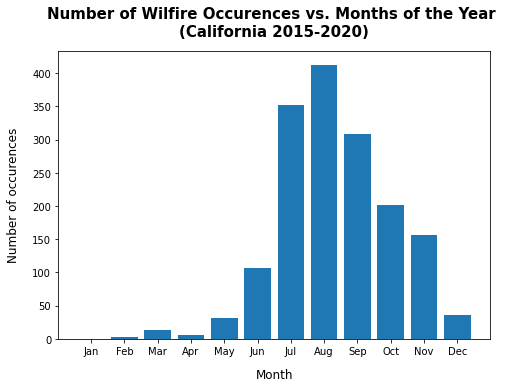

In [ ]:
acres_burned, temp, precip, month = build_pyplot_values(all_atm)
build_bar_graph(labels, month.values(), 'Number of Wilfire Occurences vs. Months of the Year \n(California 2015-2020)','Month','Number of occurences')

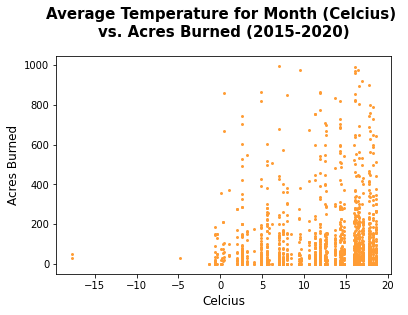

In [ ]:
build_scatter_plot_temp_acres(temp, acres_burned,'2015-2020','Celcius','Acres Burned' )

Standard Error: 52.02831761006052


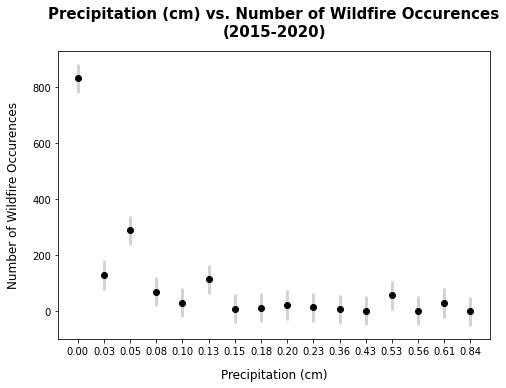

In [ ]:
build_precip_counter_bar(precip, 'Precipitation (cm) vs. Number of Wildfire Occurences\n(2015-2020)', 'Precipitation (cm)','Number of Wildfire Occurences')


  coef: 0.08790090380684148
  r-squared: 0.0077265688900595994

  


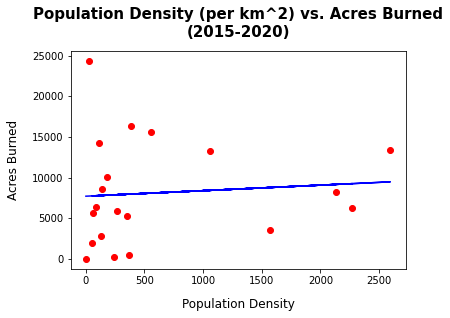

In [ ]:
pop_density, pop_dens_to_occurences, pop_dens_to_acres = get_pop_statistics(county_pop_overall)
scikit_corref_scatter(pop_density, pop_dens_to_acres, 'Population Density (per km^2) vs. Acres Burned\n(2015-2020)','Population Density','Acres Burned')

[23, 1, 29, 20, 41, 33, 15, 21, 22, 9, 16, 17, 30, 17, 7, 13, 3, 4, 8, 2]
[1.6357896470595157, 24.658615647361188, 54.72386109592157, 62.67009153196833, 88.608655075209, 109.44501617092162, 132.88862842451982, 135.63794568078526, 181.55506168761636, 244.3523362028962, 266.5931221568783, 347.93205202642076, 367.96066587705934, 385.25349257604006, 555.1767233324979, 1057.326260686868, 1568.8697496702985, 2135.970554193479, 2273.7070190989043, 2596.264712944221]
[2, 8, 13, 22, 21, 17, 3, 16, 23, 1, 33, 7, 4, 17, 20, 9, 29, 15, 30, 41]
Standard Error: 4.623928952119439


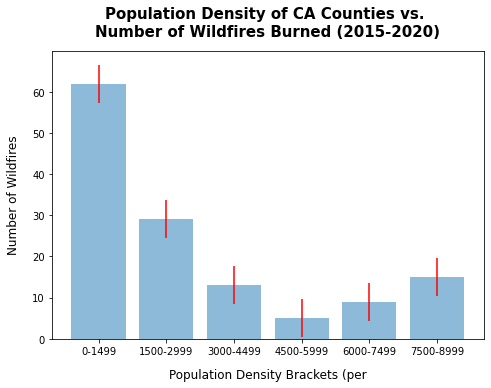

In [ ]:
# A bar graph oof pop density just for the 2015-2020 fires 

font1 = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
font2 = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
          
hold = {}


x,y = pop_density, pop_dens_to_occurences

print(pop_dens_to_occurences)

for ind,i in enumerate(x):
  hold[i] = pop_dens_to_occurences[ind]

hold_list_x = sorted(hold.keys())
hold_list_y = []
for i in hold_list_x:
  hold_list_y.append(hold[i])

standard_error = sem([62,21,13,5,9,15]*3)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Number of Wildfires', fontdict= font2, labelpad=12)
ax.set_xlabel('Population Density Brackets (per', fontdict= font2, labelpad= 12)
ax.set_title('Population Density of CA Counties vs. \nNumber of Wildfires Burned (2015-2020)', fontdict= font1, pad= 15)
ax.bar(['0-1499', '1500-2999', '3000-4499','4500-5999', '6000-7499', '7500-8999'],[62,29,13,5,9,15], alpha = 0.5, yerr=standard_error, ecolor='red')
print(hold_list_x)
print(hold_list_y)
print(f'Standard Error: {standard_error}')
#ax.errorbar(hold_list_x,hold_list_y, yerr= standard_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)

plt.show()

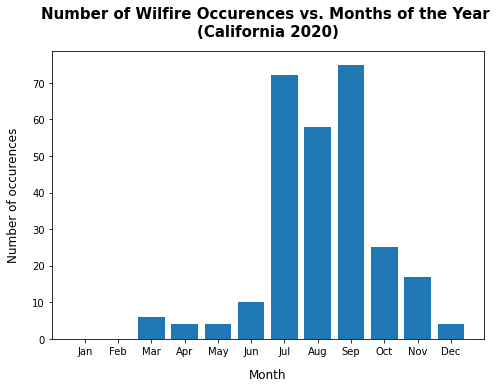

In [ ]:
acres_burned, temp, precip, month = build_pyplot_values(atm_2020)
build_bar_graph(labels, month.values(), 'Number of Wilfire Occurences vs. Months of the Year \n(California 2020)','Month','Number of occurences')

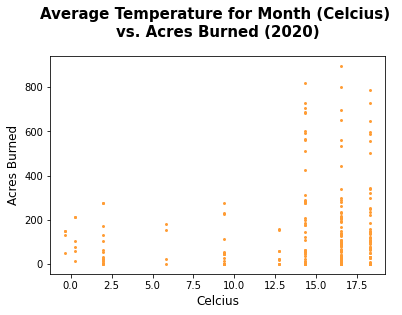

In [ ]:
build_scatter_plot_temp_acres(temp, acres_burned,'2020','Celcius','Acres Burned' )

Standard Error: 25.487796644233054


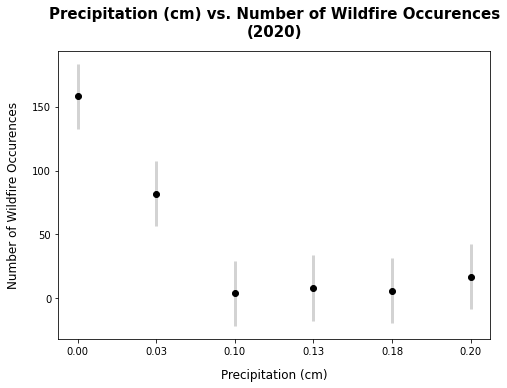

In [ ]:
build_precip_counter_bar(precip, 'Precipitation (cm) vs. Number of Wildfire Occurences\n(2020)', 'Precipitation (cm)','Number of Wildfire Occurences')


  coef: 0.5274777218712028
  r-squared: 0.27823274707043394

  


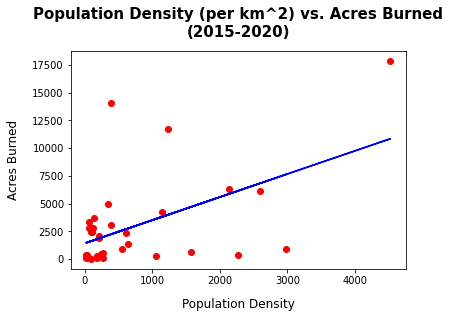

In [ ]:
pop_density, pop_dens_to_occurences, pop_dens_to_acres = get_pop_statistics(county_pop_2020)
scikit_corref_scatter(pop_density, pop_dens_to_acres, 'Population Density (per km^2) vs. Acres Burned\n(2020)','Population Density','Acres Burned')

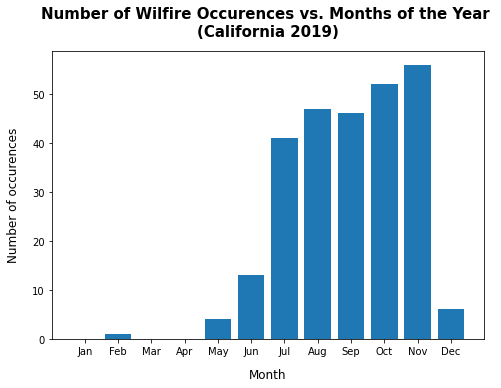

In [ ]:
acres_burned, temp, precip, month = build_pyplot_values(atm_2019)
build_bar_graph(labels, month.values(), 'Number of Wilfire Occurences vs. Months of the Year \n(California 2019)','Month','Number of occurences')

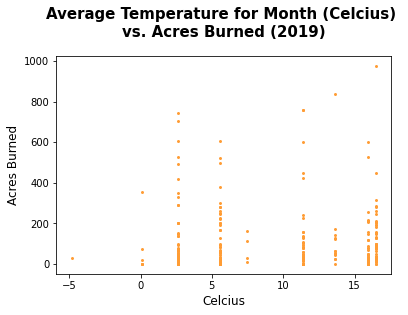

In [ ]:
build_scatter_plot_temp_acres(temp, acres_burned,'2019','Celcius','Acres Burned' )

Standard Error: 23.749619879999017


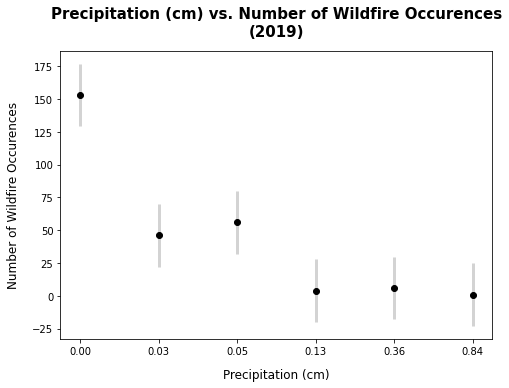

In [ ]:
build_precip_counter_bar(precip, 'Precipitation (cm) vs. Number of Wildfire Occurences\n(2019)', 'Precipitation (cm)','Number of Wildfire Occurences')


  coef: 0.26744708992777794
  r-squared: 0.07152794591083694

  


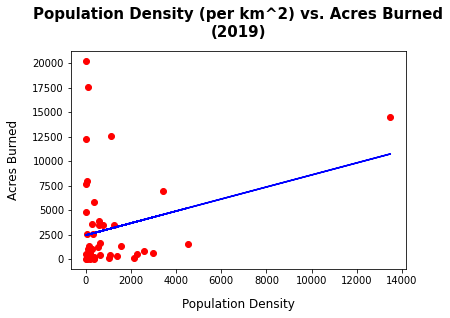

In [ ]:
pop_density, pop_dens_to_occurences, pop_dens_to_acres = get_pop_statistics(county_pop_2019)
scikit_corref_scatter(pop_density, pop_dens_to_acres, 'Population Density (per km^2) vs. Acres Burned\n(2019)','Population Density','Acres Burned')

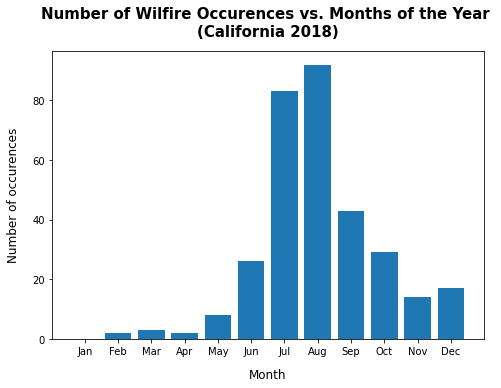

In [ ]:
acres_burned, temp, precip, month = build_pyplot_values(atm_2018)
build_bar_graph(labels, month.values(), 'Number of Wilfire Occurences vs. Months of the Year \n(California 2018)','Month','Number of occurences')

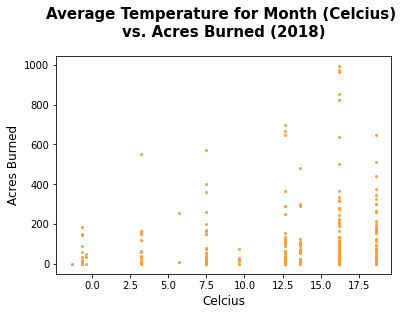

In [ ]:
build_scatter_plot_temp_acres(temp, acres_burned,'2018','Celcius','Acres Burned' )

Standard Error: 20.839040884839203


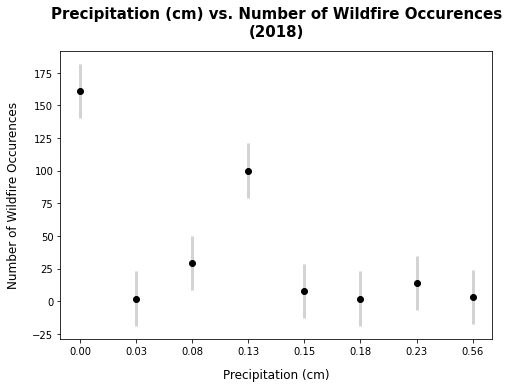

In [ ]:
build_precip_counter_bar(precip, 'Precipitation (cm) vs. Number of Wildfire Occurences\n(2018)', 'Precipitation (cm)','Number of Wildfire Occurences')

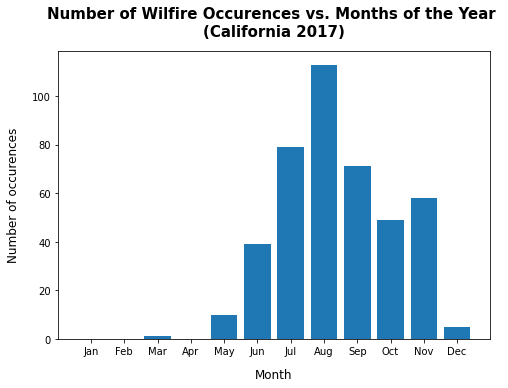

In [ ]:
acres_burned, temp, precip, month = build_pyplot_values(atm_2017)
build_bar_graph(labels, month.values(), 'Number of Wilfire Occurences vs. Months of the Year \n(California 2017)','Month','Number of occurences')

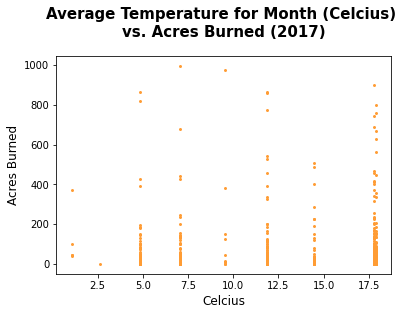

In [ ]:
build_scatter_plot_temp_acres(temp, acres_burned,'2017','Celcius','Acres Burned' )

Standard Error: 42.870735939566046


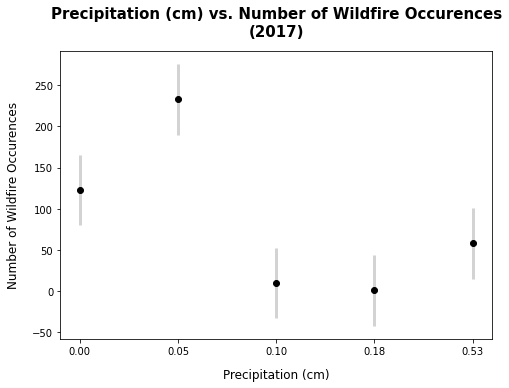

In [ ]:
build_precip_counter_bar(precip, 'Precipitation (cm) vs. Number of Wildfire Occurences\n(2017)', 'Precipitation (cm)','Number of Wildfire Occurences')


  coef: 0.341084129895784
  r-squared: 0.11633838366676406

  


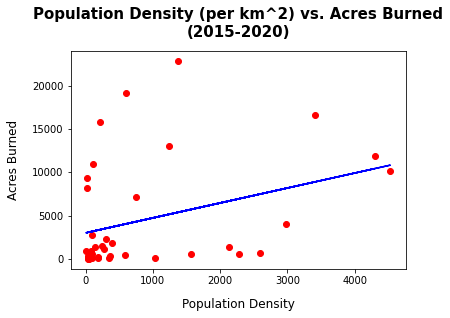

In [ ]:
pop_density, pop_dens_to_occurences, pop_dens_to_acres = get_pop_statistics(county_pop_2017)
scikit_corref_scatter(pop_density, pop_dens_to_acres, 'Population Density (per km^2) vs. Acres Burned\n(2015-2020)','Population Density','Acres Burned')

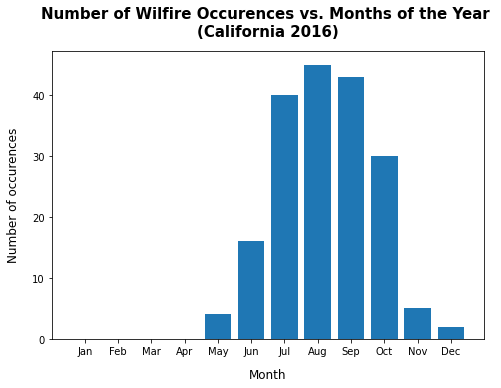

In [ ]:
acres_burned, temp, precip, month = build_pyplot_values(atm_2016)
build_bar_graph(labels, month.values(), 'Number of Wilfire Occurences vs. Months of the Year \n(California 2016)','Month','Number of occurences')

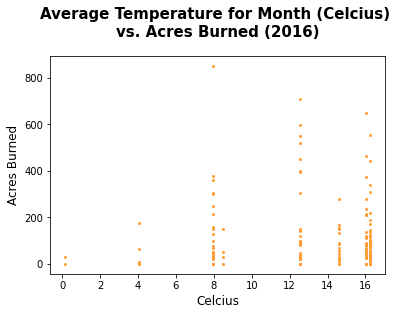

In [ ]:
build_scatter_plot_temp_acres(temp, acres_burned,'2016','Celcius','Acres Burned' )

Standard Error: 27.236005580848303


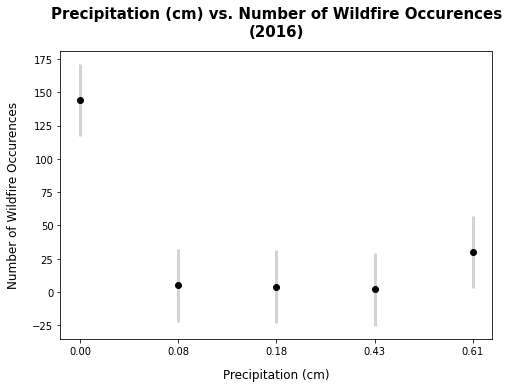

In [ ]:
build_precip_counter_bar(precip, 'Precipitation (cm) vs. Number of Wildfire Occurences\n(2016)', 'Precipitation (cm)','Number of Wildfire Occurences')


  coef: 0.44204326411754263
  r-squared: 0.19540224735169157

  


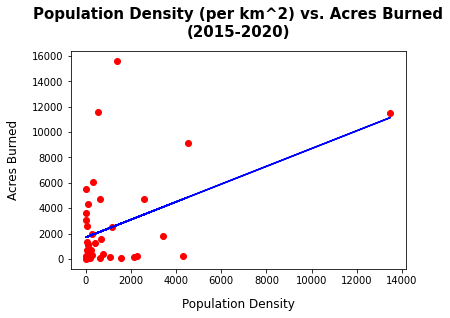

In [ ]:
pop_density, pop_dens_to_occurences, pop_dens_to_acres = get_pop_statistics(county_pop_2016)
scikit_corref_scatter(pop_density, pop_dens_to_acres, 'Population Density (per km^2) vs. Acres Burned\n(2016)','Population Density','Acres Burned')

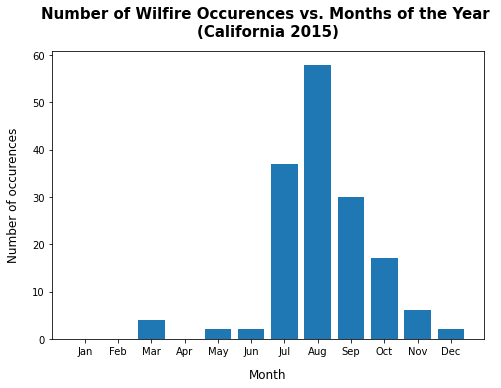

In [ ]:
acres_burned, temp, precip, month = build_pyplot_values(atm_2015)
build_bar_graph(labels, month.values(), 'Number of Wilfire Occurences vs. Months of the Year \n(California 2015)','Month','Number of occurences')

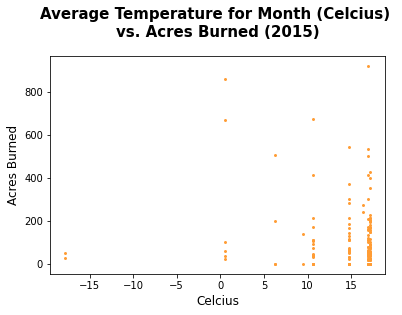

In [ ]:
build_scatter_plot_temp_acres(temp, acres_burned,'2015','Celcius','Acres Burned' )

Standard Error: 12.53919026560355


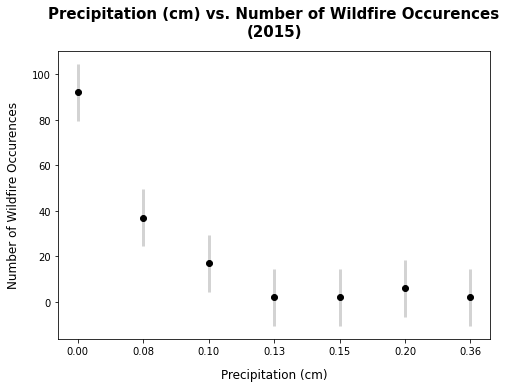

In [ ]:
build_precip_counter_bar(precip, 'Precipitation (cm) vs. Number of Wildfire Occurences\n(2015)', 'Precipitation (cm)','Number of Wildfire Occurences')


  coef: -0.11075044394829972
  r-squared: 0.012265660834745479

  


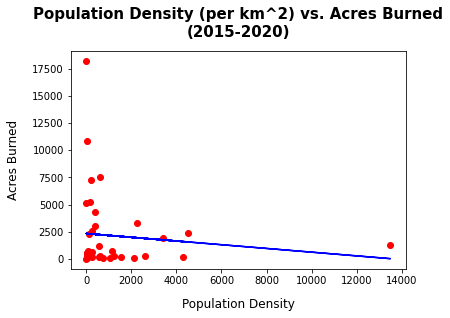

In [ ]:
pop_density, pop_dens_to_occurences, pop_dens_to_acres = get_pop_statistics(county_pop_2015)
scikit_corref_scatter(pop_density, pop_dens_to_acres, 'Population Density (per km^2) vs. Acres Burned\n(2015-2020)','Population Density','Acres Burned')

In [ ]:
# here is the data for mapping in California charts


text = '''Alameda	4
Alpine	2
Amador	1
Butte 3
Calaveras	1
Colusa	4
Contra_Costa	2
Del_Norte	1
El_Dorado	1
Fresno	3
Glenn	4
Humboldt	
Imperial	3
Inyo	3
Kern	4
Kings	1
Lake	3
Lassen	3
Los_Angeles	3
Madera	4
Marin	3
Mariposa	1
Mendocino	2
Merced	4
Modoc	3
Mono	3
Monterey	2
Napa	3
Nevada	1
Orange	5
Placer	1
Plumas	1
Riverside	3
Sacramento	4
San_Benito	1
San_Bernardino	3
San_Diego	1
San_Francisco	2
San_Joaquin	2
San_Luis_Obispo	3
San_Mateo	1
Santa_Barbara	4
Santa_Clara	1
Santa_Cruz	3
Shasta	1
Sierra	1
Siskiyou	1
Solano	3
Sonoma	4
Stanislaus	1
Sutter	4
Tehama	2
Trinity	1
Tulare	1
Tuolumne	
Ventura	5
Yolo	4
Yuba	5'''